In [7]:
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Dense, Activation, Flatten, Dropout
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU

In [1]:
# Ignore the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# System related and data input controls
import os

# Data manipulation, visualization and useful functions
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_rows = 50
pd.options.display.max_columns = 40
import numpy as np
from itertools import product # iterative combinations
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling algorithms
# General(Statistics/Econometrics)
from sklearn import preprocessing
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

# Regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Classification
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Model selection
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# Evaluation metrics
# for regression
from sklearn.metrics import mean_squared_log_error, mean_squared_error,  r2_score, mean_absolute_error
# for classification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
### Feature engineering of default
def non_feature_engineering(raw):
    if 'datetime' in raw.columns:
        raw['datetime'] = pd.to_datetime(raw['datetime'])
        raw['DateTime'] = pd.to_datetime(raw['datetime'])
    if raw.index.dtype == 'int64':
        raw.set_index('DateTime', inplace=True)
    # bring back
    # if raw.index.dtype != 'int64':
    #     raw.reset_index(drop=False, inplace=True)
    raw = raw.asfreq('H', method='ffill')
    raw_nfe = raw.copy()
    return raw_nfe
# raw_rd = non_feature_engineering(raw_all)


### Feature engineering of all
def feature_engineering(raw):
    if 'datetime' in raw.columns:
        raw['datetime'] = pd.to_datetime(raw['datetime'])
        raw['DateTime'] = pd.to_datetime(raw['datetime'])

    if raw.index.dtype == 'int64':
        raw.set_index('DateTime', inplace=True)

    raw = raw.asfreq('H', method='ffill')

    result = sm.tsa.seasonal_decompose(raw['count'], model='additive')
    Y_trend = pd.DataFrame(result.trend)
    Y_trend.fillna(method='ffill', inplace=True)
    Y_trend.fillna(method='bfill', inplace=True)
    Y_trend.columns = ['count_trend']
    Y_seasonal = pd.DataFrame(result.seasonal)
    Y_seasonal.fillna(method='ffill', inplace=True)
    Y_seasonal.fillna(method='bfill', inplace=True)
    Y_seasonal.columns = ['count_seasonal']
    pd.concat([raw, Y_trend, Y_seasonal], axis=1).isnull().sum()
    if 'count_trend' not in raw.columns:
        if 'count_seasonal' not in raw.columns:
            raw = pd.concat([raw, Y_trend, Y_seasonal], axis=1)

    Y_count_Day = raw[['count']].rolling(24).mean()
    Y_count_Day.fillna(method='ffill', inplace=True)
    Y_count_Day.fillna(method='bfill', inplace=True)
    Y_count_Day.columns = ['count_Day']
    Y_count_Week = raw[['count']].rolling(24*7).mean()
    Y_count_Week.fillna(method='ffill', inplace=True)
    Y_count_Week.fillna(method='bfill', inplace=True)
    Y_count_Week.columns = ['count_Week']
    if 'count_Day' not in raw.columns:
        raw = pd.concat([raw, Y_count_Day], axis=1)
    if 'count_Week' not in raw.columns:
        raw = pd.concat([raw, Y_count_Week], axis=1)

    Y_diff = raw[['count']].diff()
    Y_diff.fillna(method='ffill', inplace=True)
    Y_diff.fillna(method='bfill', inplace=True)
    Y_diff.columns = ['count_diff']
    if 'count_diff' not in raw.columns:
        raw = pd.concat([raw, Y_diff], axis=1)

    raw['temp_group'] = pd.cut(raw['temp'], 10)
    raw['Year'] = raw.datetime.dt.year
    raw['Quater'] = raw.datetime.dt.quarter
    raw['Quater_ver2'] = raw['Quater'] + (raw.Year - raw.Year.min()) * 4
    raw['Month'] = raw.datetime.dt.month
    raw['Day'] = raw.datetime.dt.day
    raw['Hour'] = raw.datetime.dt.hour
    raw['DayofWeek'] = raw.datetime.dt.dayofweek

    raw['count_lag1'] = raw['count'].shift(1)
    raw['count_lag2'] = raw['count'].shift(2)
    raw['count_lag1'].fillna(method='bfill', inplace=True)
    raw['count_lag2'].fillna(method='bfill', inplace=True)

    if 'Quater' in raw.columns:
        if 'Quater_Dummy' not in ['_'.join(col.split('_')[:2]) for col in raw.columns]:
            raw = pd.concat([raw, pd.get_dummies(raw['Quater'], 
                                                 prefix='Quater_Dummy', drop_first=True)], axis=1)
            del raw['Quater']
    raw_fe = raw.copy()
    return raw_fe
# raw_fe = feature_engineering(raw_all)


### Data split of cross sectional
def datasplit_cs(raw, Y_colname, X_colname, test_size, random_seed=123):
    X_train, X_test, Y_train, Y_test = train_test_split(raw[X_colname], raw[Y_colname], test_size=test_size, random_state=random_seed)
    print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
    print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)
    return X_train, X_test, Y_train, Y_test
# X_train, X_test, Y_train, Y_test = datasplit_cs(raw_fe, Y_colname, X_colname, 0.2)


### Data split of time series
def datasplit_ts(raw, Y_colname, X_colname, criteria):
    raw_train = raw.loc[raw.index < criteria,:]
    raw_test = raw.loc[raw.index >= criteria,:]
    Y_train = raw_train[Y_colname]
    X_train = raw_train[X_colname]
    Y_test = raw_test[Y_colname]
    X_test = raw_test[X_colname]
    print('Train_size:', raw_train.shape, 'Test_size:', raw_test.shape)
    print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
    print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)
    return X_train, X_test, Y_train, Y_test
# X_train, X_test, Y_train, Y_test = datasplit_ts(raw_fe, Y_colname, X_colname, '2012-07-01')


### Evaluation of 1 pair of set
def evaluation(Y_real, Y_pred, graph_on=False):
    loss_length = len(Y_real.values.flatten()) - len(Y_pred)
    if loss_length != 0:
        Y_real = Y_real[loss_length:]
    if graph_on == True:
        pd.concat([Y_real, pd.DataFrame(Y_pred, index=Y_real.index, columns=['prediction'])], axis=1).plot(kind='line', figsize=(20,6),
                                                                                                           xlim=(Y_real.index.min(),Y_real.index.max()),
                                                                                                           linewidth=3, fontsize=20)
        plt.title('Time Series of Target', fontsize=20)
        plt.xlabel('Index', fontsize=15)
        plt.ylabel('Target Value', fontsize=15)
    MAE = abs(Y_real.values.flatten() - Y_pred).mean()
    MSE = ((Y_real.values.flatten() - Y_pred)**2).mean()
    MAPE = (abs(Y_real.values.flatten() - Y_pred)/Y_real.values.flatten()*100).mean()
    Score = pd.DataFrame([MAE, MSE, MAPE], index=['MAE', 'MSE', 'MAPE'], columns=['Score']).T
    Residual = pd.DataFrame(Y_real.values.flatten() - Y_pred, index=Y_real.index, columns=['Error'])
    return Score, Residual
# Score_tr, Residual_tr = evaluation(Y_train, pred_tr_reg1, graph_on=True)


### Evaluation of train/test pairs
def evaluation_trte(Y_real_tr, Y_pred_tr, Y_real_te, Y_pred_te, graph_on=False):
    Score_tr, Residual_tr = evaluation(Y_real_tr, Y_pred_tr, graph_on=graph_on)
    Score_te, Residual_te = evaluation(Y_real_te, Y_pred_te, graph_on=graph_on)
    Score_trte = pd.concat([Score_tr, Score_te], axis=0)
    Score_trte.index = ['Train', 'Test']
    return Score_trte, Residual_tr, Residual_te
# Score_reg1, Resid_tr_reg1, Resid_te_reg1 = evaluation_trte(Y_train, pred_tr_reg1, Y_test, pred_te_reg1, graph_on=True)


### Error analysis
def stationarity_adf_test(Y_Data, Target_name):
    if len(Target_name) == 0:
        Stationarity_adf = pd.Series(sm.tsa.stattools.adfuller(Y_Data)[0:4],
                                     index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
        for key, value in sm.tsa.stattools.adfuller(Y_Data)[4].items():
            Stationarity_adf['Critical Value(%s)'%key] = value
            Stationarity_adf['Maximum Information Criteria'] = sm.tsa.stattools.adfuller(Y_Data)[5]
            Stationarity_adf = pd.DataFrame(Stationarity_adf, columns=['Stationarity_adf'])
    else:
        Stationarity_adf = pd.Series(sm.tsa.stattools.adfuller(Y_Data[Target_name])[0:4],
                                     index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
        for key, value in sm.tsa.stattools.adfuller(Y_Data[Target_name])[4].items():
            Stationarity_adf['Critical Value(%s)'%key] = value
            Stationarity_adf['Maximum Information Criteria'] = sm.tsa.stattools.adfuller(Y_Data[Target_name])[5]
            Stationarity_adf = pd.DataFrame(Stationarity_adf, columns=['Stationarity_adf'])
    return Stationarity_adf

def stationarity_kpss_test(Y_Data, Target_name):
    if len(Target_name) == 0:
        Stationarity_kpss = pd.Series(sm.tsa.stattools.kpss(Y_Data)[0:3],
                                      index=['Test Statistics', 'p-value', 'Used Lag'])
        for key, value in sm.tsa.stattools.kpss(Y_Data)[3].items():
            Stationarity_kpss['Critical Value(%s)'%key] = value
            Stationarity_kpss = pd.DataFrame(Stationarity_kpss, columns=['Stationarity_kpss'])
    else:
        Stationarity_kpss = pd.Series(sm.tsa.stattools.kpss(Y_Data[Target_name])[0:3],
                                      index=['Test Statistics', 'p-value', 'Used Lag'])
        for key, value in sm.tsa.stattools.kpss(Y_Data[Target_name])[3].items():
            Stationarity_kpss['Critical Value(%s)'%key] = value
            Stationarity_kpss = pd.DataFrame(Stationarity_kpss, columns=['Stationarity_kpss'])
    return Stationarity_kpss

def error_analysis(Y_Data, Target_name, X_Data, graph_on=False):
    for x in Target_name:
        Target_name = x
    X_Data = X_Data.loc[Y_Data.index]

    if graph_on == True:
        ##### Error Analysis(Plot)
        Y_Data['RowNum'] = Y_Data.reset_index().index

        # Stationarity(Trend) Analysis
        sns.set(palette="muted", color_codes=True, font_scale=2)
        sns.lmplot(x='RowNum', y=Target_name, data=Y_Data, fit_reg='True', size=5.2, aspect=2, ci=99, sharey=True)
        del Y_Data['RowNum']

        # Normal Distribution Analysis
        figure, axes = plt.subplots(figsize=(12,8))
        sns.distplot(Y_Data[Target_name], norm_hist='True', fit=stats.norm, ax=axes)

        # Lag Analysis
        length = int(len(Y_Data[Target_name])/10)
        figure, axes = plt.subplots(1, 4, figsize=(12,3))
        pd.plotting.lag_plot(Y_Data[Target_name], lag=1, ax=axes[0])
        pd.plotting.lag_plot(Y_Data[Target_name], lag=5, ax=axes[1])
        pd.plotting.lag_plot(Y_Data[Target_name], lag=10, ax=axes[2])
        pd.plotting.lag_plot(Y_Data[Target_name], lag=50, ax=axes[3])

        # Autocorrelation Analysis
        figure, axes = plt.subplots(2,1,figsize=(12,5))
        sm.tsa.graphics.plot_acf(Y_Data[Target_name], lags=100, use_vlines=True, ax=axes[0])
        sm.tsa.graphics.plot_pacf(Y_Data[Target_name], lags=100, use_vlines=True, ax=axes[1])

    ##### Error Analysis(Statistics)
    # Checking Stationarity
    # Null Hypothesis: The Time-series is non-stationalry
    Stationarity_adf = stationarity_adf_test(Y_Data, Target_name)
    Stationarity_kpss = stationarity_kpss_test(Y_Data, Target_name)

    # Checking of Normality
    # Null Hypothesis: The residuals are normally distributed
    Normality = pd.DataFrame([stats.shapiro(Y_Data[Target_name])],
                             index=['Normality'], columns=['Test Statistics', 'p-value']).T

    # Checking for Autocorrelation
    # Null Hypothesis: Autocorrelation is absent
    Autocorrelation = pd.concat([pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Y_Data[Target_name], lags=[1,5,10,50])[0], columns=['Test Statistics']),
                                 pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Y_Data[Target_name], lags=[1,5,10,50])[1], columns=['p-value'])], axis=1).T
    Autocorrelation.columns = ['Autocorr(lag1)', 'Autocorr(lag5)', 'Autocorr(lag10)', 'Autocorr(lag50)']

    # Checking Heteroscedasticity
    # Null Hypothesis: Error terms are homoscedastic
    Heteroscedasticity = pd.DataFrame([sm.stats.diagnostic.het_goldfeldquandt(Y_Data[Target_name], X_Data.values, alternative='two-sided')],
                                      index=['Heteroscedasticity'], columns=['Test Statistics', 'p-value', 'Alternative']).T
    Score = pd.concat([Stationarity_adf, Stationarity_kpss, Normality, Autocorrelation, Heteroscedasticity], join='outer', axis=1)
    index_new = ['Test Statistics', 'p-value', 'Alternative', 'Used Lag', 'Used Observations',
                 'Critical Value(1%)', 'Critical Value(5%)', 'Critical Value(10%)', 'Maximum Information Criteria']
    Score.reindex(index_new)
    return Score
# error_analysis(Resid_tr_reg1[1:], ['Error'], X_train, graph_on=True)

# MLP

In [11]:
# Data Loading
location = './Data/RealestateKorea_Gangnam/Economy.csv'
raw_all = pd.read_csv(location)
raw_all

# Feature Engineering
raw_all['Date'] = pd.to_datetime(raw_all['Date'])
raw_all.index = raw_all['Date']
raw_all = raw_all[raw_all.index >= '2010-01-01']
raw_all = raw_all[raw_all.index <= '2017-12-31']
raw_all.fillna(method='bfill', inplace=True)

# Data Split
Y_colname = ['Price']
X_remove = ['Date', 'Price_Sido']
X_colname = [x for x in raw_all.columns if x not in Y_colname+X_remove]
X_train, X_test, Y_train, Y_test = datasplit_ts(raw_all, Y_colname, X_colname, '2016-01-01')

# Parameters
scaler_X_tr = preprocessing.MinMaxScaler()
scaler_Y_tr = preprocessing.MinMaxScaler()
# sequence = 34
batch_size = 32
epoch = 20
verbose = 1
dropout_ratio = 0

Train_size: (4760, 18) Test_size: (1632, 18)
X_train: (4760, 15) Y_train: (4760, 1)
X_test: (1632, 15) Y_test: (1632, 1)


In [12]:
# Feature Engineering
## Scaling
X_train = scaler_X_tr.fit_transform(X_train)
Y_train = scaler_Y_tr.fit_transform(Y_train)
X_test = scaler_X_tr.transform(X_test)
Y_test = scaler_Y_tr.transform(Y_test)

## Retype and Reshape
# X_train = X_train.reshape(X_train.shape[0], sequence, -1)
# X_test = X_test.reshape(X_test.shape[0], sequence, -1)
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

X_train: (4760, 15) Y_train: (4760, 1)
X_test: (1632, 15) Y_test: (1632, 1)


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               2048      
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 10,369
Trainable params: 10,369
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
149/149 [==============================] - 0s 1ms/step - loss: 0.0445
Epoch 2/20
149/149 [===============

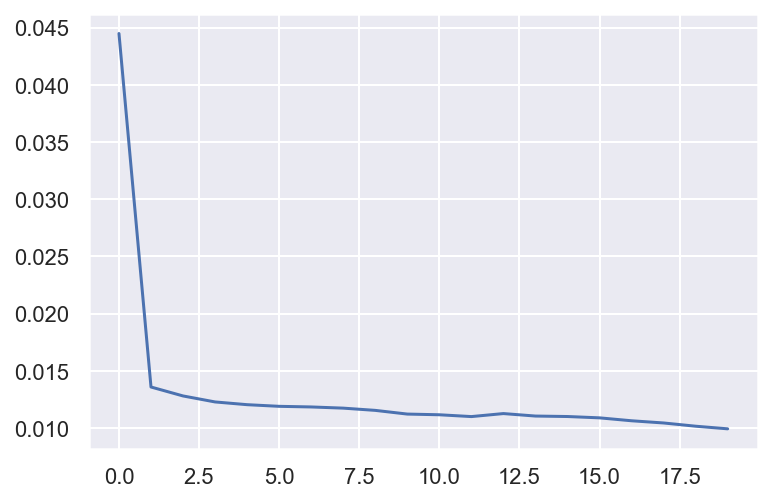

51/51 [==============================] - 0s 763us/step - loss: 4.1949e-15


,MAE,MSE,MAPE
Train,3.50,23.16,3.92
Test,7.20,68.47,7.26


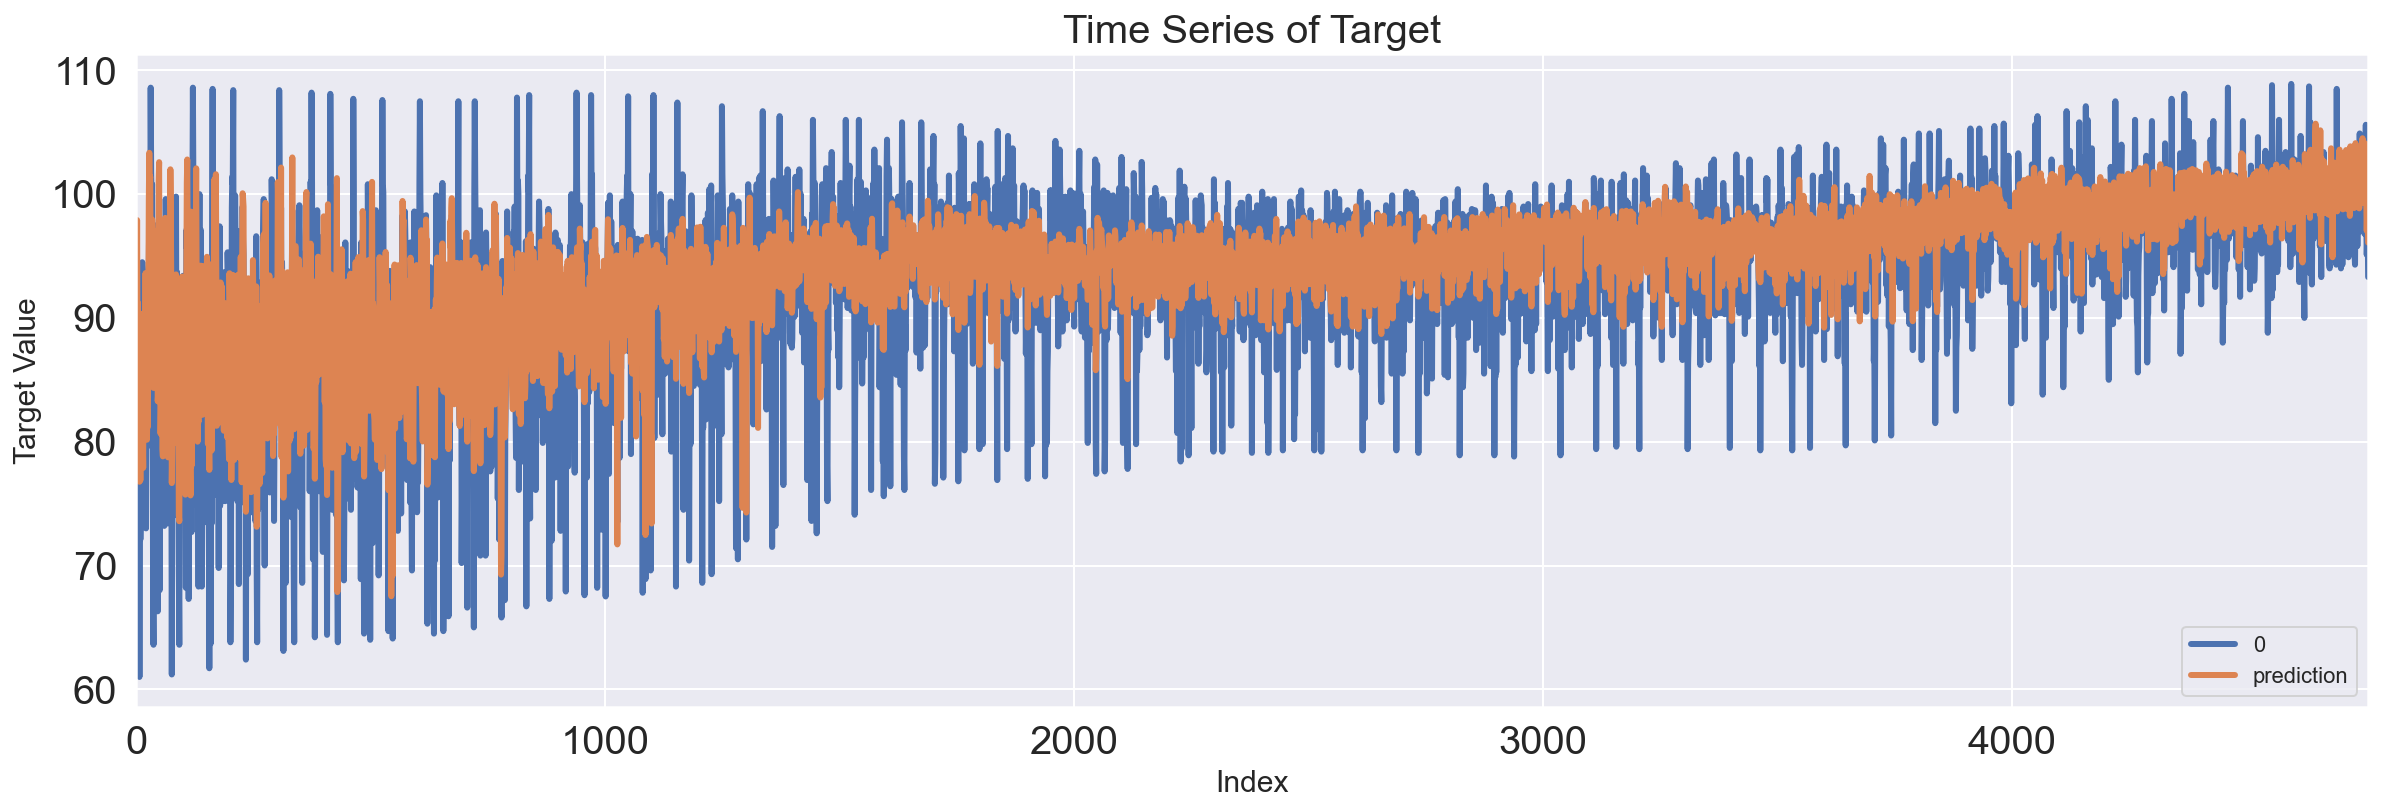

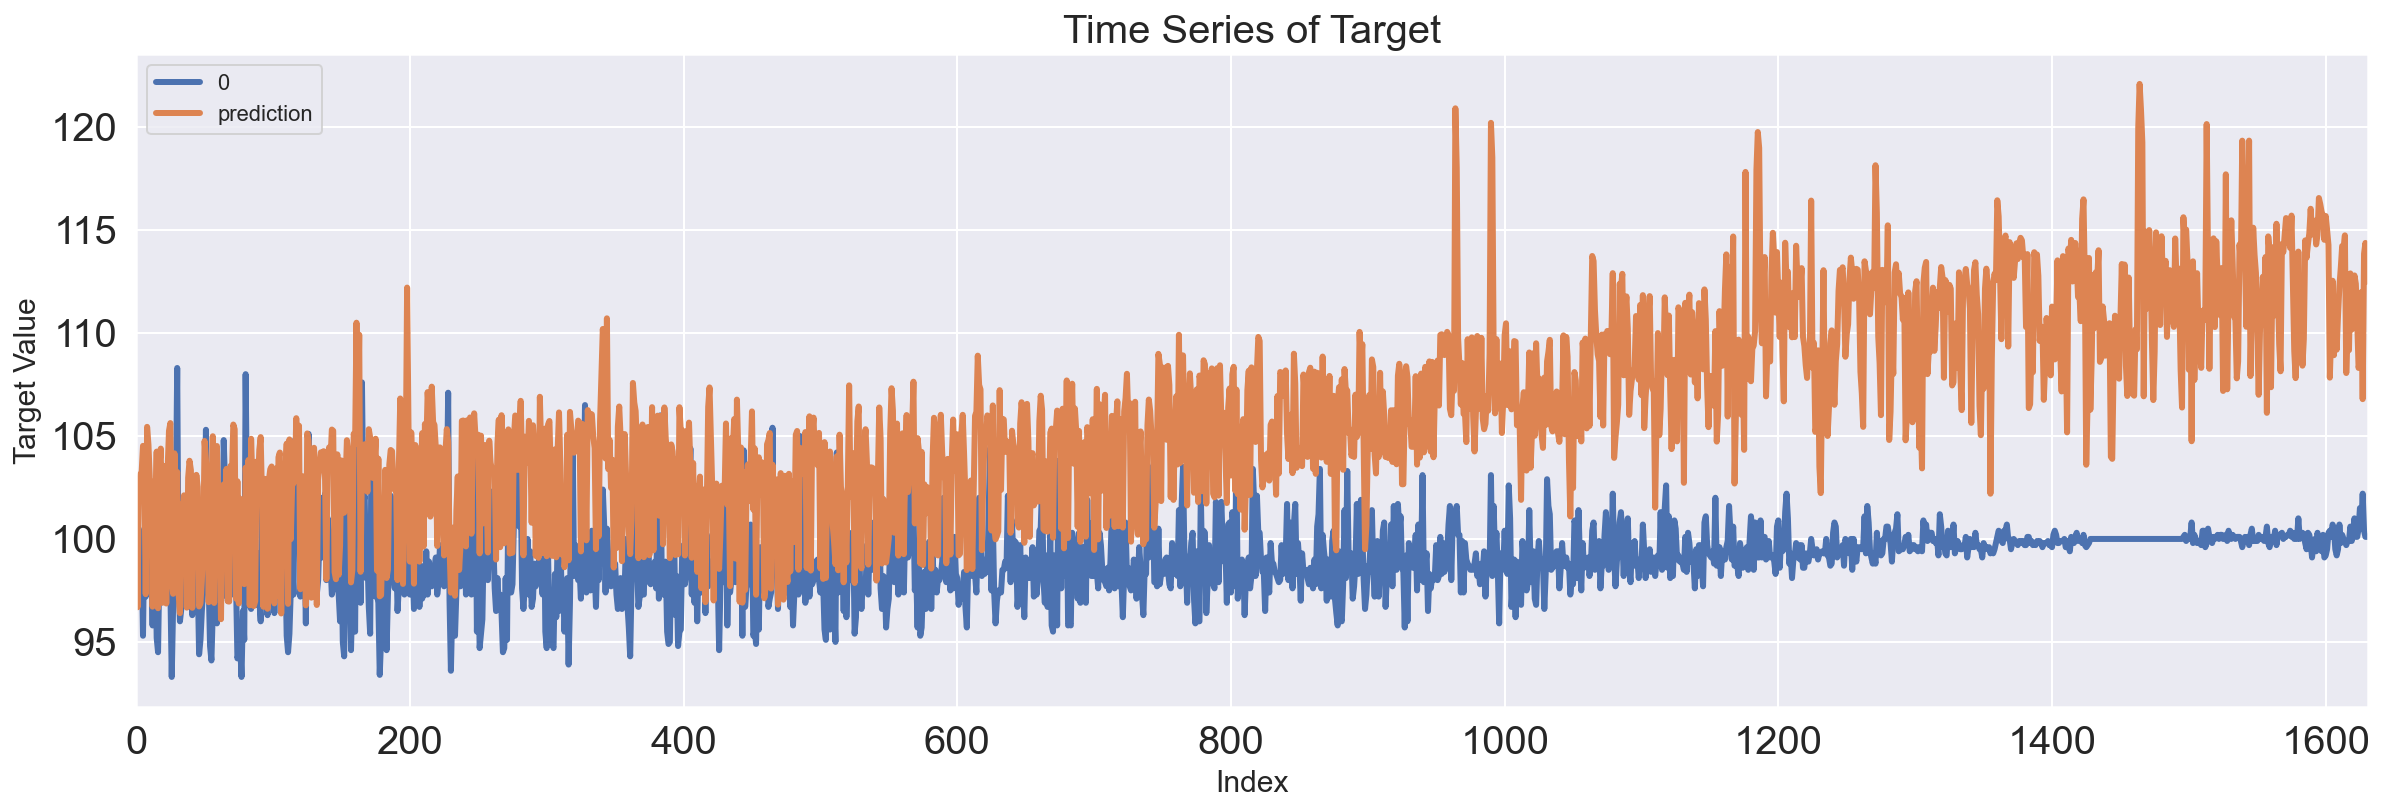

In [13]:
# MLP
model = Sequential()
model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dropout(dropout_ratio)) 
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(dropout_ratio)) 
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(dropout_ratio)) 
model.add(Dense(64, activation='relu'))
model.add(Dropout(dropout_ratio)) 
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
model_fit = model.fit(X_train, Y_train, 
                      batch_size=batch_size, epochs=epoch,
                      verbose=verbose)

plt.plot(pd.DataFrame(model_fit.history))
plt.grid(True)
plt.show()

# prediction
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

# evaluation
result = model.evaluate(X_test, Y_test_pred)
if scaler_Y_tr != []:
    Y_train = scaler_Y_tr.inverse_transform(Y_train)
    Y_train_pred = scaler_Y_tr.inverse_transform(Y_train_pred)
    Y_test = scaler_Y_tr.inverse_transform(Y_test)
    Y_test_pred = scaler_Y_tr.inverse_transform(Y_test_pred)
Score_MLP, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(Y_train), Y_train_pred.flatten(), 
                                                      pd.DataFrame(Y_test), Y_test_pred.flatten(), graph_on=True)
display(Score_MLP)

# error analysis
# error_analysis(Residual_te, ['Error'], X_test_feR.reset_index().iloc[:,1:].loc[Residual_te.index], graph_on=True)

# GRU (Sequence = 34)

Train_size: (4760, 18) Test_size: (1632, 18)
X_train: (4760, 15) Y_train: (4760, 1)
X_test: (1632, 15) Y_test: (1632, 1)
X_train: (4726, 34, 15) Y_train: (4726, 1)
X_test: (1598, 34, 15) Y_test: (1598, 1)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 34, 128)           55680     
_________________________________________________________________
dropout_2 (Dropout)          (None, 34, 128)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                37248     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 92,993
Trainable params: 92,993
N

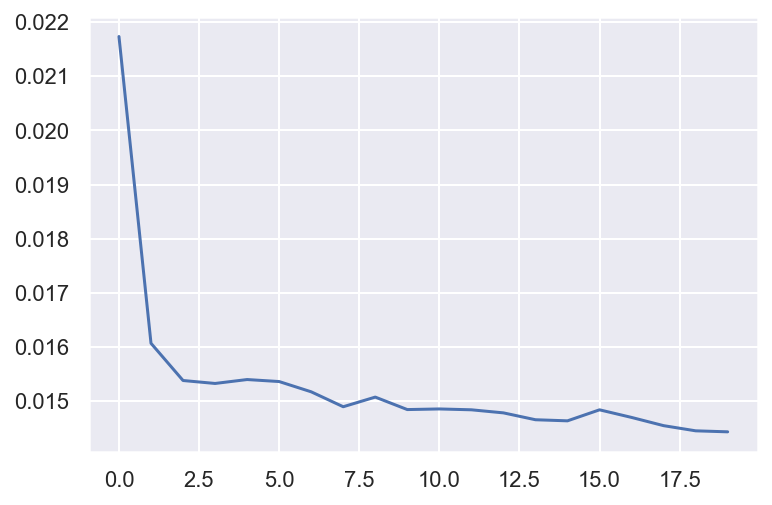

50/50 [==============================] - 1s 10ms/step - loss: 1.8808e-15


,MAE,MSE,MAPE
Train,4.20,32.52,4.72
Test,2.13,6.28,2.16


NameError: name 'X_test_feR' is not defined

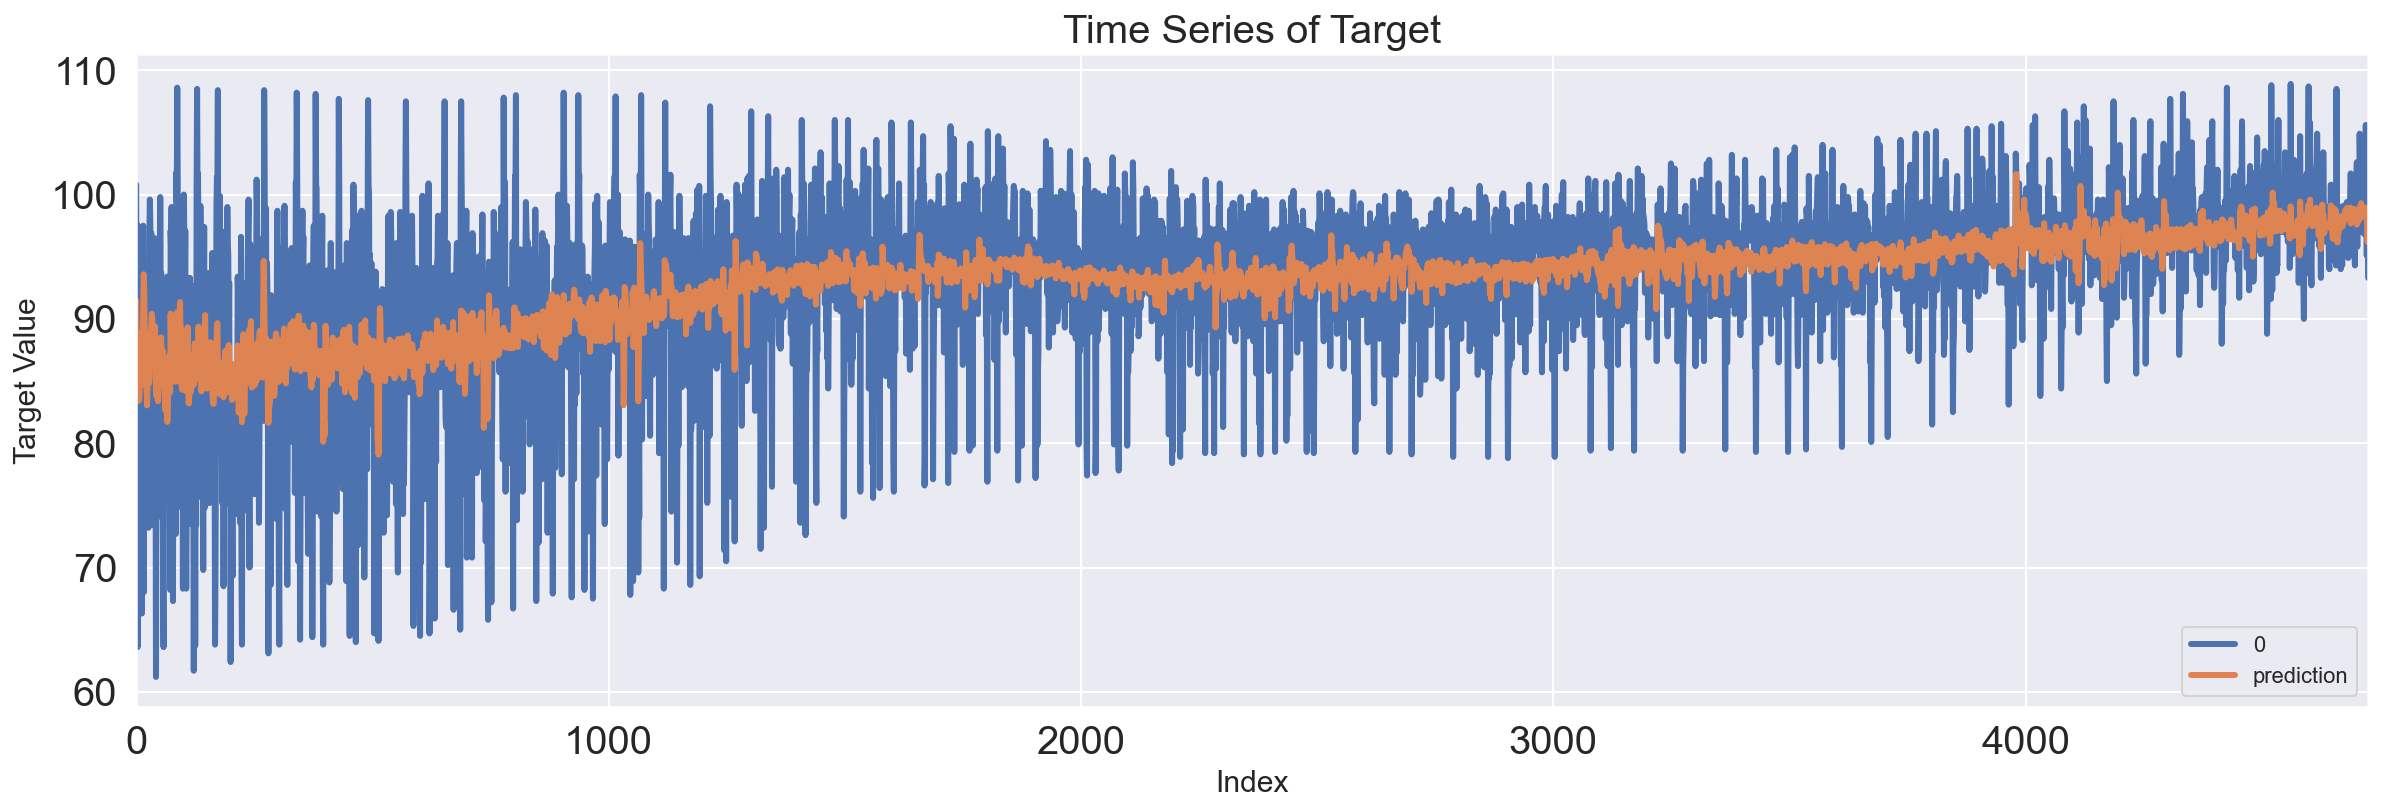

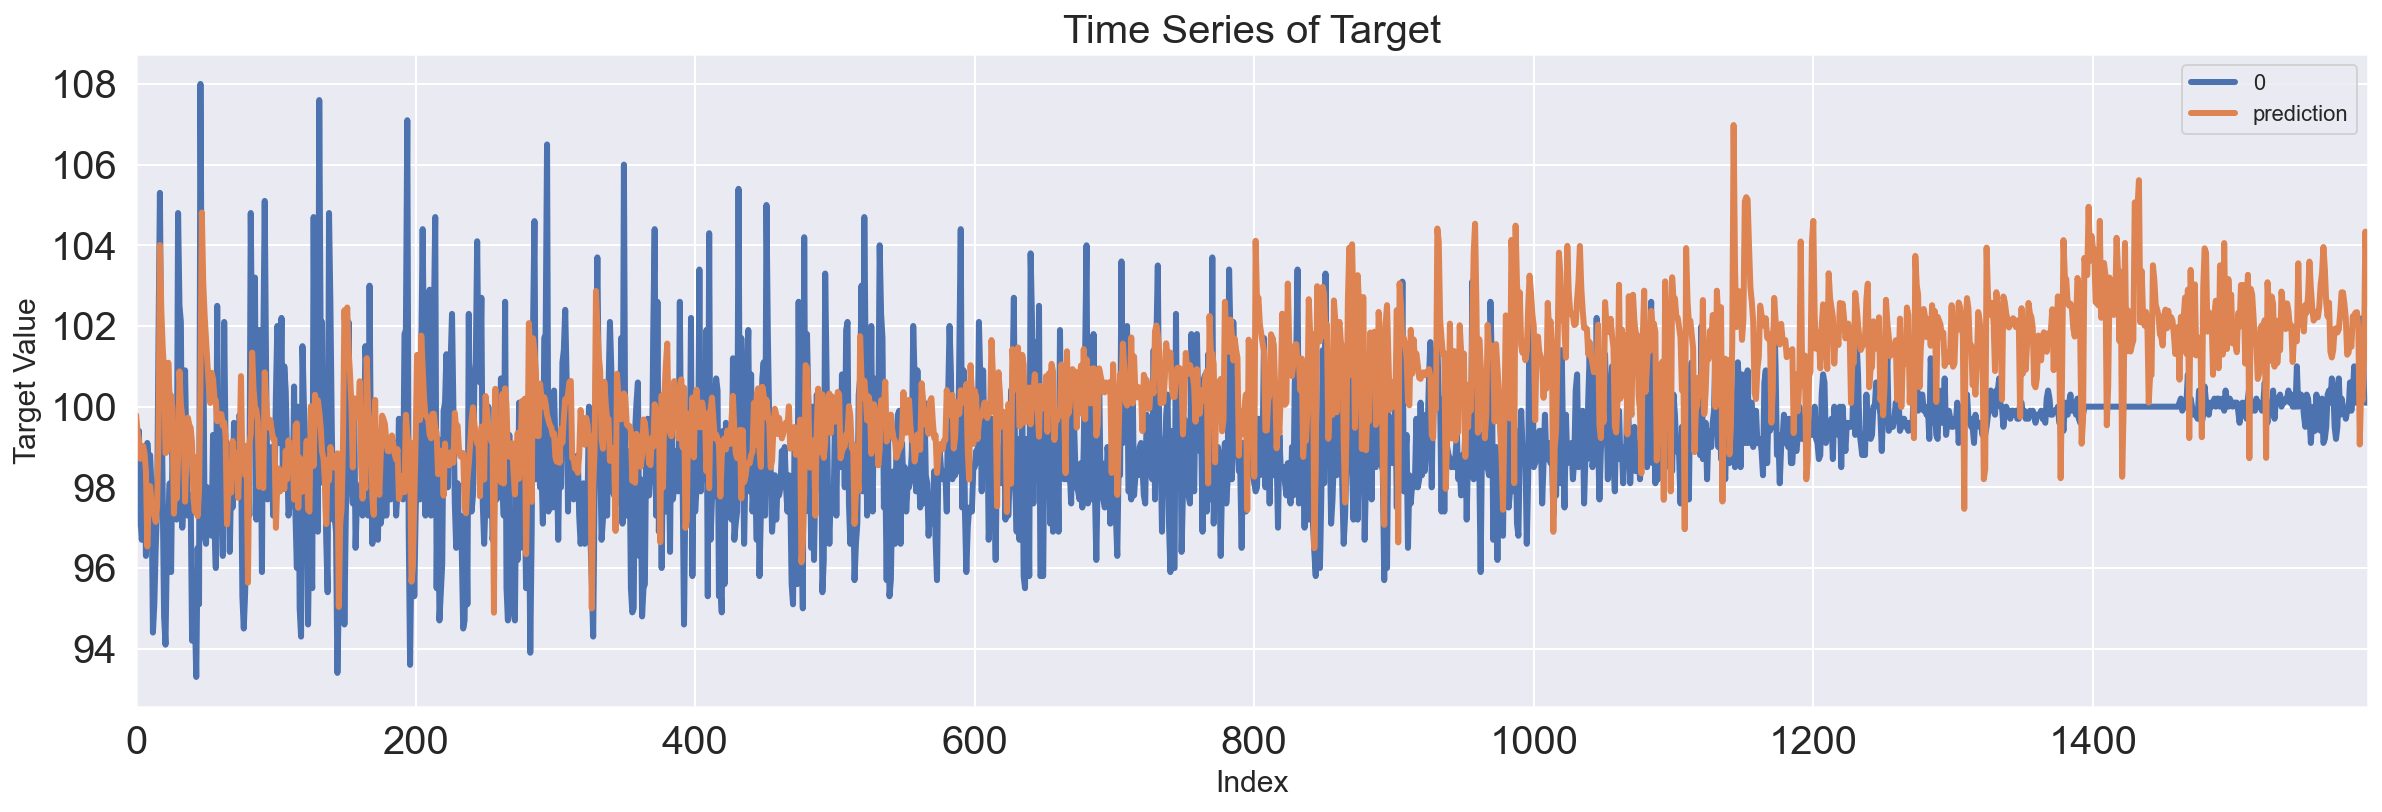

In [9]:
# Data Loading
location = './Data/RealestateKorea_Gangnam/Economy.csv'
raw_all = pd.read_csv(location)
raw_all

# Feature Engineering
raw_all['Date'] = pd.to_datetime(raw_all['Date'])
raw_all.index = raw_all['Date']
raw_all = raw_all[raw_all.index >= '2010-01-01']
raw_all = raw_all[raw_all.index <= '2017-12-31']
raw_all.fillna(method='bfill', inplace=True)

# Data Split
Y_colname = ['Price']
X_remove = ['Date', 'Price_Sido']
X_colname = [x for x in raw_all.columns if x not in Y_colname+X_remove]
X_train, X_test, Y_train, Y_test = datasplit_ts(raw_all, Y_colname, X_colname, '2016-01-01')

# Parameters
scaler_X_tr = preprocessing.MinMaxScaler()
scaler_Y_tr = preprocessing.MinMaxScaler()
sequence = 34
batch_size = 32
epoch = 20
verbose = 1
dropout_ratio = 0

# Feature Engineering
## Scaling
X_train_scaled = scaler_X_tr.fit_transform(X_train)
Y_train_scaled = scaler_Y_tr.fit_transform(Y_train)
X_test_scaled = scaler_X_tr.transform(X_test)
Y_test_scaled = scaler_Y_tr.transform(Y_test)

## X / Y Split
X_train, Y_train = [], []
for index in range(len(X_train_scaled) - sequence):
    X_train.append(np.array(X_train_scaled[index: index + sequence]))
    Y_train.append(np.ravel(Y_train_scaled[index + sequence:index + sequence + 1]))
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_test, Y_test = [], []
for index in range(len(X_test_scaled) - sequence):
    X_test.append(np.array(X_test_scaled[index: index + sequence]))
    Y_test.append(np.ravel(Y_test_scaled[index + sequence:index + sequence + 1]))  
X_test, Y_test = np.array(X_test), np.array(Y_test) 

## Retype and Reshape
X_train = X_train.reshape(X_train.shape[0], sequence, -1)
X_test = X_test.reshape(X_test.shape[0], sequence, -1)
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

# GRU
model = Sequential()
model.add(GRU(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu'))
model.add(Dropout(dropout_ratio)) 
# model.add(GRU(256, return_sequences=True, activation="relu"))
# model.add(Dropout(dropout_ratio)) 
# model.add(GRU(128, return_sequences=True, activation="relu"))
# model.add(Dropout(dropout_ratio)) 
model.add(GRU(64, return_sequences=False, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
model_fit = model.fit(X_train, Y_train, 
                      batch_size=batch_size, epochs=epoch,
                      verbose=verbose)

plt.plot(pd.DataFrame(model_fit.history))
plt.grid(True)
plt.show()

# prediction
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

# evaluation
result = model.evaluate(X_test, Y_test_pred)
if scaler_Y_tr != []:
    Y_train = scaler_Y_tr.inverse_transform(Y_train)
    Y_train_pred = scaler_Y_tr.inverse_transform(Y_train_pred)
    Y_test = scaler_Y_tr.inverse_transform(Y_test)
    Y_test_pred = scaler_Y_tr.inverse_transform(Y_test_pred)
Score_GRU, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(Y_train), Y_train_pred.flatten(), 
                                                      pd.DataFrame(Y_test), Y_test_pred.flatten(), graph_on=True)
display(Score_GRU)

# error analysis
# error_analysis(Residual_te, ['Error'], X_test_feR.reset_index().iloc[:,1:].loc[Residual_te.index], graph_on=True)

## Other Case:1

In [14]:
# Data Loading
location = './Data/RealestateKorea_Gangnam/Economy.csv'
raw_all = pd.read_csv(location)
date = raw_all['Date'].unique()
raw_all = raw_all.groupby(['Year', 'Month']).mean().reset_index().iloc[:,2:]
raw_all['Date'] = date
raw_all

,Price,Region,Price_Sido,Building_Type,Construction_Amount,CD_Rate,Deposit_Rate,Exchange_Rate,Composite_Stock_Price,Economy_Growth,Exchequer_Bond_3Y,Household_Loan_All,Mortgage_All,Number_Of_Nosells,Unsalenum,Date
0,75.17,"36,750.00",75.05,2.75,"4,867,793.00",4.15,4.06,971.00,"1,379.32",1.80,5.02,NaN,NaN,NaN,NaN,2006-01-01
1,75.46,"36,750.00",75.17,2.75,"4,862,500.00",4.25,4.13,969.00,"1,341.72",1.80,4.87,NaN,NaN,NaN,NaN,2006-02-01
2,75.72,"36,750.00",75.46,2.75,"6,313,640.00",4.27,4.20,975.90,"1,331.72",1.80,4.93,NaN,NaN,NaN,NaN,2006-03-01
3,75.98,"36,750.00",75.72,2.75,"6,303,213.00",4.33,4.33,945.70,"1,415.92",0.60,4.95,NaN,NaN,NaN,NaN,2006-04-01
4,76.12,"36,750.00",75.98,2.75,"6,410,478.00",4.36,4.31,947.40,"1,388.83",0.60,4.78,NaN,NaN,NaN,NaN,2006-05-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,100.15,"36,705.88",100.17,2.75,"12,821,605.00",1.65,1.83,"1,121.70","2,394.51",NaN,2.18,"998,893.00","587,660.80",304.33,61.24,2018-06-01
150,100.11,"36,705.88",100.15,2.75,"10,891,515.00",1.65,1.79,"1,116.70","2,284.25",NaN,2.10,NaN,NaN,575.88,148.53,2018-07-01
151,100.23,"36,705.88",100.11,2.75,NaN,1.65,NaN,"1,108.80",NaN,NaN,2.02,NaN,NaN,311.24,103.00,2018-08-01
152,100.34,"36,705.88",100.23,2.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,490.56,92.75,2018-09-01


In [15]:
# Feature Engineering
raw_all['Date'] = pd.to_datetime(raw_all['Date'])
raw_all.index = raw_all['Date']
raw_all = raw_all[raw_all.index >= '2010-01-01']
raw_all = raw_all[raw_all.index <= '2017-12-31']
raw_all.fillna(method='bfill', inplace=True)

# Data Split
Y_colname = ['Price']
X_remove = ['Date', 'Region', 'Price_Sido', 'Building_Type']
X_colname = [x for x in raw_all.columns if x not in Y_colname+X_remove]
X_train, X_test, Y_train, Y_test = datasplit_ts(raw_all, Y_colname, X_colname, '2016-01-01')

Train_size: (72, 16) Test_size: (24, 16)
X_train: (72, 11) Y_train: (72, 1)
X_test: (24, 11) Y_test: (24, 1)


X_train: (60, 12, 11) Y_train: (60, 1)
X_test: (12, 12, 11) Y_test: (12, 1)
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 12, 128)           54144     
_________________________________________________________________
dropout_6 (Dropout)          (None, 12, 128)           0         
_________________________________________________________________
gru_3 (GRU)                  (None, 12, 256)           296448    
_________________________________________________________________
dropout_7 (Dropout)          (None, 12, 256)           0         
_________________________________________________________________
gru_4 (GRU)                  (None, 12, 128)           148224    
_________________________________________________________________
dropout_8 (Dropout)          (None, 12, 128)           0         
____________________________________________

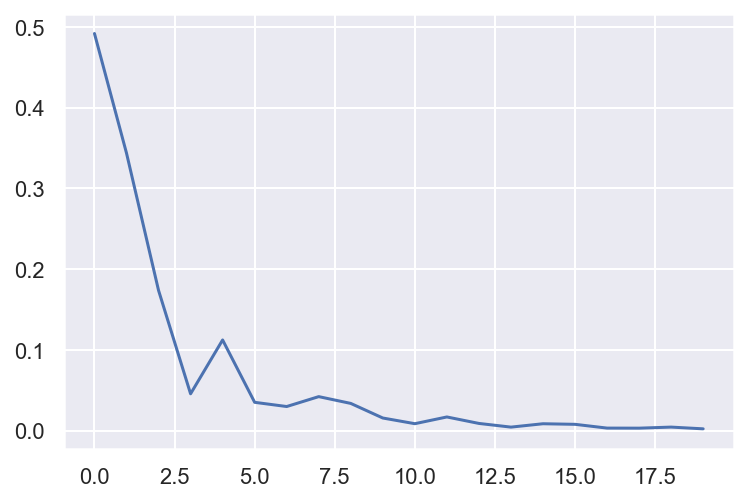

1/1 [==============================] - 0s 2ms/step - loss: 4.7370e-15


,MAE,MSE,MAPE
Train,0.45,0.32,0.48
Test,4.61,22.13,4.63


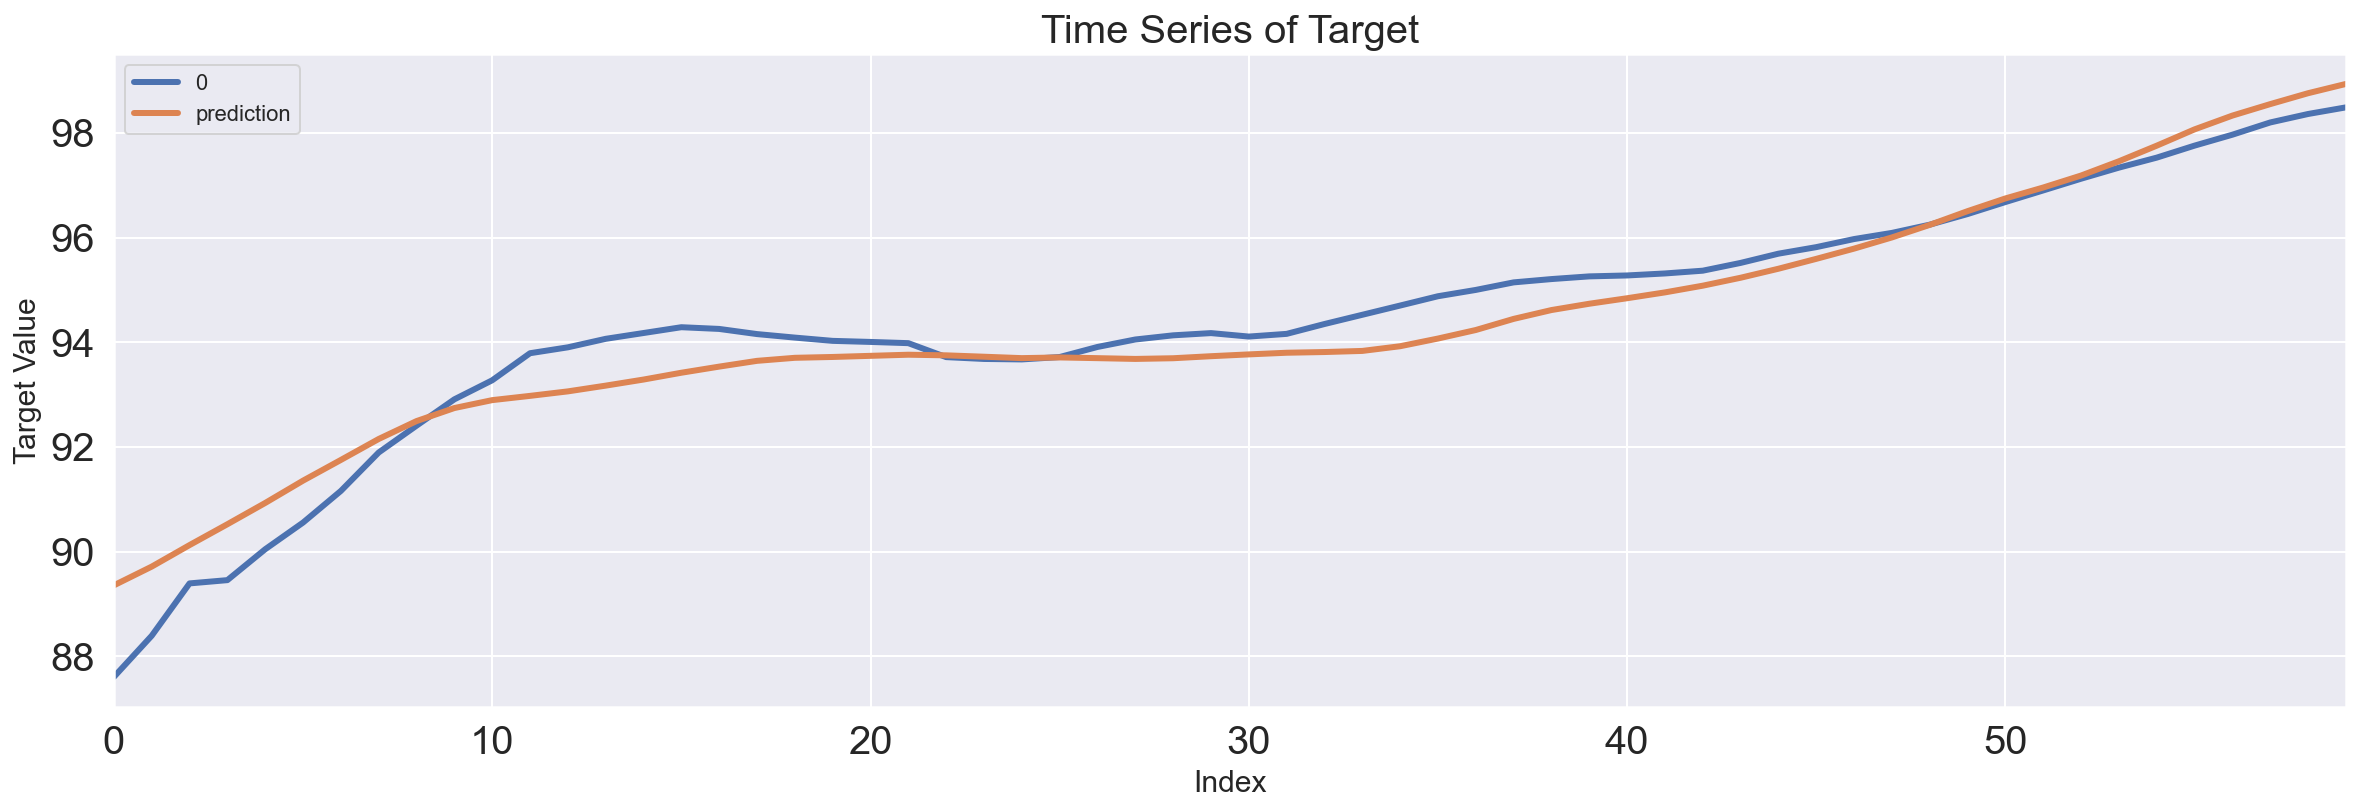

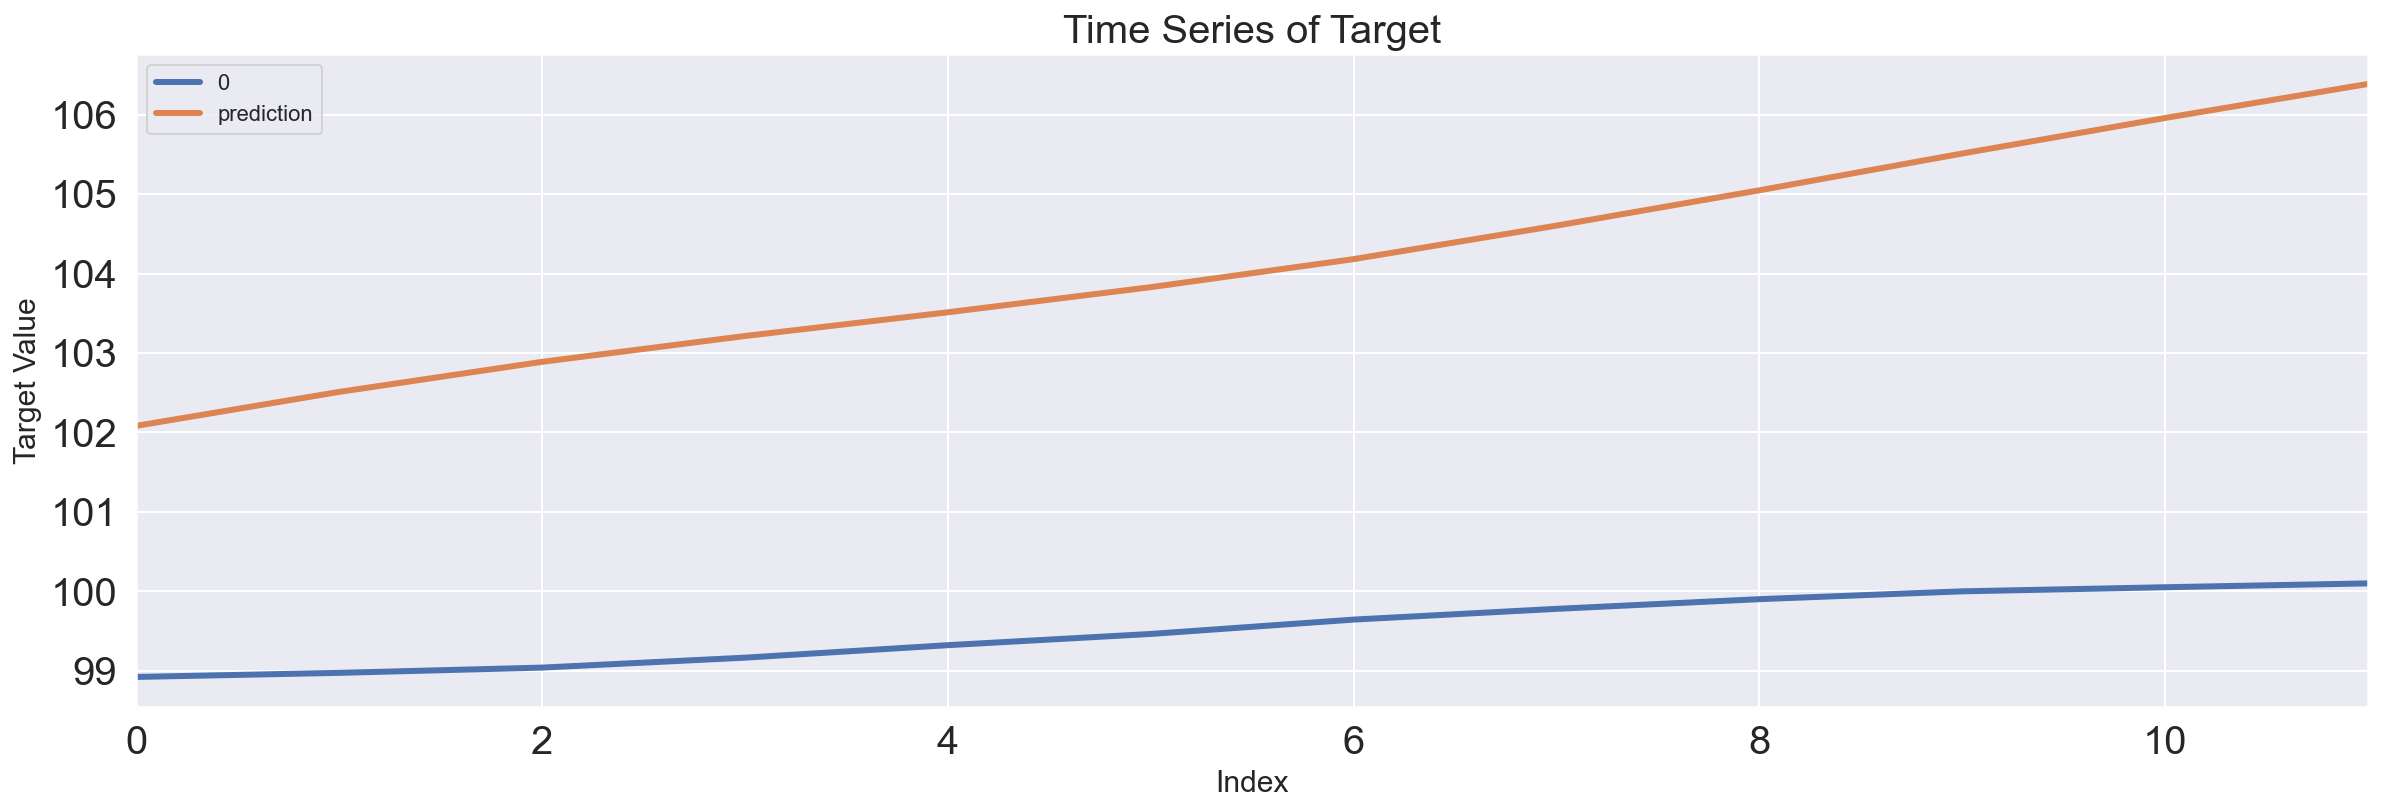

In [16]:
# Parameters
scaler_X_tr = preprocessing.MinMaxScaler()
scaler_Y_tr = preprocessing.MinMaxScaler()
sequence = 12
batch_size = 32
epoch = 20
verbose = 1
dropout_ratio = 0

# Feature Engineering
## Scaling
X_train_scaled = scaler_X_tr.fit_transform(X_train)
Y_train_scaled = scaler_Y_tr.fit_transform(Y_train)
X_test_scaled = scaler_X_tr.transform(X_test)
Y_test_scaled = scaler_Y_tr.transform(Y_test)

## X / Y Split
X_train, Y_train = [], []
for index in range(len(X_train_scaled) - sequence):
    X_train.append(np.array(X_train_scaled[index: index + sequence]))
    Y_train.append(np.ravel(Y_train_scaled[index + sequence:index + sequence + 1]))
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_test, Y_test = [], []
for index in range(len(X_test_scaled) - sequence):
    X_test.append(np.array(X_test_scaled[index: index + sequence]))
    Y_test.append(np.ravel(Y_test_scaled[index + sequence:index + sequence + 1]))  
X_test, Y_test = np.array(X_test), np.array(Y_test) 

## Retype and Reshape
X_train = X_train.reshape(X_train.shape[0], sequence, -1)
X_test = X_test.reshape(X_test.shape[0], sequence, -1)
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

# GRU
model = Sequential()
model.add(GRU(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu'))
model.add(Dropout(dropout_ratio)) 
model.add(GRU(256, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(GRU(128, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(GRU(64, return_sequences=False, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
model_fit = model.fit(X_train, Y_train, 
                      batch_size=batch_size, epochs=epoch,
                      verbose=verbose)

plt.plot(pd.DataFrame(model_fit.history))
plt.grid(True)
plt.show()

# prediction
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

# evaluation
result = model.evaluate(X_test, Y_test_pred)
if scaler_Y_tr != []:
    Y_train = scaler_Y_tr.inverse_transform(Y_train)
    Y_train_pred = scaler_Y_tr.inverse_transform(Y_train_pred)
    Y_test = scaler_Y_tr.inverse_transform(Y_test)
    Y_test_pred = scaler_Y_tr.inverse_transform(Y_test_pred)
Score_GRU, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(Y_train), Y_train_pred.flatten(), 
                                                      pd.DataFrame(Y_test), Y_test_pred.flatten(), graph_on=True)
display(Score_GRU)

# error analysis
# error_analysis(Residual_te, ['Error'], X_test_feR.reset_index().iloc[:,1:].loc[Residual_te.index], graph_on=True)

### Optimal Sequence

In [17]:
# Data Loading
location = './Data/RealestateKorea_Gangnam/Economy.csv'
raw_all = pd.read_csv(location)
date = raw_all['Date'].unique()
raw_all = raw_all.groupby(['Year', 'Month']).mean().reset_index().iloc[:,2:]
raw_all['Date'] = date
raw_all

# Feature Engineering
raw_all['Date'] = pd.to_datetime(raw_all['Date'])
raw_all.index = raw_all['Date']
raw_all = raw_all[raw_all.index >= '2010-01-01']
raw_all = raw_all[raw_all.index <= '2017-12-31']
raw_all.fillna(method='bfill', inplace=True)

# Data Split
Y_colname = ['Price']
X_remove = ['Date', 'Region', 'Price_Sido', 'Building_Type']
X_colname = [x for x in raw_all.columns if x not in Y_colname+X_remove]
X_train, X_test, Y_train, Y_test = datasplit_ts(raw_all, Y_colname, X_colname, '2016-01-01')

Train_size: (72, 16) Test_size: (24, 16)
X_train: (72, 11) Y_train: (72, 1)
X_test: (24, 11) Y_test: (24, 1)


In [18]:
# Parameters
scaler_X_tr = preprocessing.MinMaxScaler()
scaler_Y_tr = preprocessing.MinMaxScaler()
sequence = 12
batch_size = 32
epoch = 20
verbose = 0
dropout_ratio = 0

# Feature Engineering
## Scaling
X_train_scaled = scaler_X_tr.fit_transform(X_train)
Y_train_scaled = scaler_Y_tr.fit_transform(Y_train)
X_test_scaled = scaler_X_tr.transform(X_test)
Y_test_scaled = scaler_Y_tr.transform(Y_test)

In [19]:
####################### iterations #######################
Score = dict()
seqsize_list = [i for i in range(1, 15, 1)]
for i in tqdm(seqsize_list):
    sequence = i

    ## X / Y Split
    X_train, Y_train = [], []
    for index in range(len(X_train_scaled) - sequence):
        X_train.append(np.array(X_train_scaled[index: index + sequence]))
        Y_train.append(np.ravel(Y_train_scaled[index + sequence:index + sequence + 1]))
    X_train, Y_train = np.array(X_train), np.array(Y_train)
    X_test, Y_test = [], []
    for index in range(len(X_test_scaled) - sequence):
        X_test.append(np.array(X_test_scaled[index: index + sequence]))
        Y_test.append(np.ravel(Y_test_scaled[index + sequence:index + sequence + 1]))  
    X_test, Y_test = np.array(X_test), np.array(Y_test) 

    ## Retype and Reshape
    X_train = X_train.reshape(X_train.shape[0], sequence, -1)
    X_test = X_test.reshape(X_test.shape[0], sequence, -1)
    print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
    print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

    # GRU
    model = Sequential()
    model.add(GRU(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu'))
    model.add(Dropout(dropout_ratio)) 
    model.add(GRU(256, return_sequences=True, activation="relu"))
    model.add(Dropout(dropout_ratio)) 
    model.add(GRU(128, return_sequences=True, activation="relu"))
    model.add(Dropout(dropout_ratio)) 
    model.add(GRU(64, return_sequences=False, activation="relu"))
    model.add(Dropout(dropout_ratio)) 
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    # model.summary()
    model_fit = model.fit(X_train, Y_train, 
                          batch_size=batch_size, epochs=epoch,
                          verbose=verbose)

    # plt.plot(pd.DataFrame(model_fit.history))
    # plt.grid(True)
    # plt.show()

    # prediction
    Y_train_pred = model.predict(X_train)
    Y_test_pred = model.predict(X_test)

    # evaluation
    result = model.evaluate(X_test, Y_test_pred)
    if scaler_Y_tr != []:
        Y_train = scaler_Y_tr.inverse_transform(Y_train)
        Y_train_pred = scaler_Y_tr.inverse_transform(Y_train_pred)
        Y_test = scaler_Y_tr.inverse_transform(Y_test)
        Y_test_pred = scaler_Y_tr.inverse_transform(Y_test_pred)
    Score_GRU, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(Y_train), Y_train_pred.flatten(), 
                                                          pd.DataFrame(Y_test), Y_test_pred.flatten(), graph_on=False)
#     display(Score_GRU)
    Score[str(sequence)] = Score_GRU

    # error analysis
    # error_analysis(Residual_te, ['Error'], X_test_feR.reset_index().iloc[:,1:].loc[Residual_te.index], graph_on=True)

  0%|          | 0/14 [00:00<?, ?it/s]

X_train: (71, 1, 11) Y_train: (71, 1)
X_test: (23, 1, 11) Y_test: (23, 1)
1/1 [==============================] - 0s 988us/step - loss: 1.2975e-14


  7%|▋         | 1/14 [00:09<02:08,  9.90s/it]

X_train: (70, 2, 11) Y_train: (70, 1)
X_test: (22, 2, 11) Y_test: (22, 1)
1/1 [==============================] - 0s 997us/step - loss: 5.8135e-15


 14%|█▍        | 2/14 [00:19<01:59,  9.93s/it]

X_train: (69, 3, 11) Y_train: (69, 1)
X_test: (21, 3, 11) Y_test: (21, 1)
1/1 [==============================] - 0s 991us/step - loss: 4.9061e-15


 21%|██▏       | 3/14 [00:29<01:50, 10.01s/it]

X_train: (68, 4, 11) Y_train: (68, 1)
X_test: (20, 4, 11) Y_test: (20, 1)
1/1 [==============================] - 0s 2ms/step - loss: 5.6843e-15


 29%|██▊       | 4/14 [00:39<01:39,  9.99s/it]

X_train: (67, 5, 11) Y_train: (67, 1)
X_test: (19, 5, 11) Y_test: (19, 1)
1/1 [==============================] - 0s 3ms/step - loss: 8.9753e-15


 36%|███▌      | 5/14 [00:50<01:32, 10.29s/it]

X_train: (66, 6, 11) Y_train: (66, 1)
X_test: (18, 6, 11) Y_test: (18, 1)
1/1 [==============================] - 0s 2ms/step - loss: 4.7370e-15


 43%|████▎     | 6/14 [01:01<01:24, 10.51s/it]

X_train: (65, 7, 11) Y_train: (65, 1)
X_test: (17, 7, 11) Y_test: (17, 1)
1/1 [==============================] - 0s 996us/step - loss: 3.3437e-15


 50%|█████     | 7/14 [01:13<01:15, 10.79s/it]

X_train: (64, 8, 11) Y_train: (64, 1)
X_test: (16, 8, 11) Y_test: (16, 1)
1/1 [==============================] - 0s 996us/step - loss: 3.5527e-15


 57%|█████▋    | 8/14 [01:22<01:01, 10.25s/it]

X_train: (63, 9, 11) Y_train: (63, 1)
X_test: (15, 9, 11) Y_test: (15, 1)
1/1 [==============================] - 0s 1ms/step - loss: 6.6317e-15


 64%|██████▍   | 9/14 [01:32<00:52, 10.43s/it]

X_train: (62, 10, 11) Y_train: (62, 1)
X_test: (14, 10, 11) Y_test: (14, 1)
1/1 [==============================] - 0s 996us/step - loss: 5.0753e-15


 71%|███████▏  | 10/14 [01:43<00:42, 10.56s/it]

X_train: (61, 11, 11) Y_train: (61, 1)
X_test: (13, 11, 11) Y_test: (13, 1)
1/1 [==============================] - 0s 2ms/step - loss: 5.4657e-15


 79%|███████▊  | 11/14 [01:54<00:31, 10.64s/it]

X_train: (60, 12, 11) Y_train: (60, 1)
X_test: (12, 12, 11) Y_test: (12, 1)
1/1 [==============================] - 0s 997us/step - loss: 3.5527e-15


 86%|████████▌ | 12/14 [02:05<00:21, 10.58s/it]

X_train: (59, 13, 11) Y_train: (59, 1)
X_test: (11, 13, 11) Y_test: (11, 1)
1/1 [==============================] - 0s 999us/step - loss: 5.1676e-15


 93%|█████████▎| 13/14 [02:16<00:10, 10.89s/it]

X_train: (58, 14, 11) Y_train: (58, 1)
X_test: (10, 14, 11) Y_test: (10, 1)
1/1 [==============================] - 0s 1ms/step - loss: 9.9476e-15


100%|██████████| 14/14 [02:29<00:00, 10.66s/it]


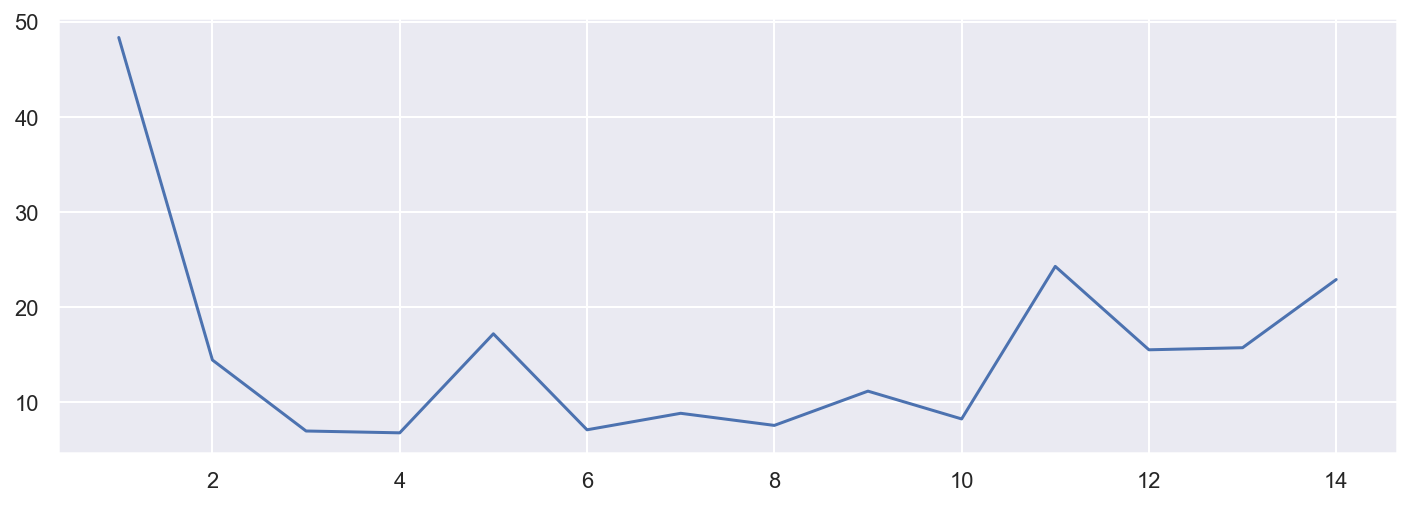

In [20]:
# Performance plot by sequence length
seq_test = pd.DataFrame()
for key, val in Score.items():
    seq_test = pd.concat([seq_test, val.iloc[1,:].T], axis=1)

seq_test = seq_test.T
seq_test.index = seqsize_list
seq_test['MSE'].plot(figsize=(12,4))
plt.show()

### Optimal Batch

In [21]:
# Data Loading
location = './Data/RealestateKorea_Gangnam/Economy.csv'
raw_all = pd.read_csv(location)
date = raw_all['Date'].unique()
raw_all = raw_all.groupby(['Year', 'Month']).mean().reset_index().iloc[:,2:]
raw_all['Date'] = date
raw_all

# Feature Engineering
raw_all['Date'] = pd.to_datetime(raw_all['Date'])
raw_all.index = raw_all['Date']
raw_all = raw_all[raw_all.index >= '2010-01-01']
raw_all = raw_all[raw_all.index <= '2017-12-31']
raw_all.fillna(method='bfill', inplace=True)

# Data Split
Y_colname = ['Price']
X_remove = ['Date', 'Region', 'Price_Sido', 'Building_Type']
X_colname = [x for x in raw_all.columns if x not in Y_colname+X_remove]
X_train, X_test, Y_train, Y_test = datasplit_ts(raw_all, Y_colname, X_colname, '2016-01-01')

# Parameters
scaler_X_tr = preprocessing.MinMaxScaler()
scaler_Y_tr = preprocessing.MinMaxScaler()
sequence = 4
batch_size = 32
epoch = 20
verbose = 0
dropout_ratio = 0

# Feature Engineering
## Scaling
X_train_scaled = scaler_X_tr.fit_transform(X_train)
Y_train_scaled = scaler_Y_tr.fit_transform(Y_train)
X_test_scaled = scaler_X_tr.transform(X_test)
Y_test_scaled = scaler_Y_tr.transform(Y_test)

####################### iterations #######################
Score = dict()
batchsize_list = [i for i in range(5, 50, 5)]
for i in tqdm(batchsize_list):
    batch_size = i

    ## X / Y Split
    X_train, Y_train = [], []
    for index in range(len(X_train_scaled) - sequence):
        X_train.append(np.array(X_train_scaled[index: index + sequence]))
        Y_train.append(np.ravel(Y_train_scaled[index + sequence:index + sequence + 1]))
    X_train, Y_train = np.array(X_train), np.array(Y_train)
    X_test, Y_test = [], []
    for index in range(len(X_test_scaled) - sequence):
        X_test.append(np.array(X_test_scaled[index: index + sequence]))
        Y_test.append(np.ravel(Y_test_scaled[index + sequence:index + sequence + 1]))  
    X_test, Y_test = np.array(X_test), np.array(Y_test) 

    ## Retype and Reshape
    X_train = X_train.reshape(X_train.shape[0], sequence, -1)
    X_test = X_test.reshape(X_test.shape[0], sequence, -1)
    print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
    print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

    # GRU
    model = Sequential()
    model.add(GRU(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu'))
    model.add(Dropout(dropout_ratio)) 
    model.add(GRU(256, return_sequences=True, activation="relu"))
    model.add(Dropout(dropout_ratio)) 
    model.add(GRU(128, return_sequences=True, activation="relu"))
    model.add(Dropout(dropout_ratio)) 
    model.add(GRU(64, return_sequences=False, activation="relu"))
    model.add(Dropout(dropout_ratio)) 
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    # model.summary()
    model_fit = model.fit(X_train, Y_train, 
                          batch_size=batch_size, epochs=epoch,
                          verbose=verbose)

    # plt.plot(pd.DataFrame(model_fit.history))
    # plt.grid(True)
    # plt.show()

    # prediction
    Y_train_pred = model.predict(X_train)
    Y_test_pred = model.predict(X_test)

    # evaluation
    result = model.evaluate(X_test, Y_test_pred)
    if scaler_Y_tr != []:
        Y_train = scaler_Y_tr.inverse_transform(Y_train)
        Y_train_pred = scaler_Y_tr.inverse_transform(Y_train_pred)
        Y_test = scaler_Y_tr.inverse_transform(Y_test)
        Y_test_pred = scaler_Y_tr.inverse_transform(Y_test_pred)
    Score_GRU, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(Y_train), Y_train_pred.flatten(), 
                                                          pd.DataFrame(Y_test), Y_test_pred.flatten(), graph_on=False)
#     display(Score_GRU)
    Score[str(batch_size)] = Score_GRU

    # error analysis
    # error_analysis(Residual_te, ['Error'], X_test_feR.reset_index().iloc[:,1:].loc[Residual_te.index], graph_on=True)

Train_size: (72, 16) Test_size: (24, 16)
X_train: (72, 11) Y_train: (72, 1)
X_test: (24, 11) Y_test: (24, 1)


  0%|          | 0/9 [00:00<?, ?it/s]

X_train: (68, 4, 11) Y_train: (68, 1)
X_test: (20, 4, 11) Y_test: (20, 1)
1/1 [==============================] - 0s 999us/step - loss: 5.6843e-15


 11%|█         | 1/9 [00:15<02:01, 15.18s/it]

X_train: (68, 4, 11) Y_train: (68, 1)
X_test: (20, 4, 11) Y_test: (20, 1)
1/1 [==============================] - 0s 2ms/step - loss: 4.2633e-15


 22%|██▏       | 2/9 [00:28<01:38, 14.04s/it]

X_train: (68, 4, 11) Y_train: (68, 1)
X_test: (20, 4, 11) Y_test: (20, 1)
1/1 [==============================] - 0s 999us/step - loss: 1.2790e-14


 33%|███▎      | 3/9 [00:39<01:16, 12.75s/it]

X_train: (68, 4, 11) Y_train: (68, 1)
X_test: (20, 4, 11) Y_test: (20, 1)
1/1 [==============================] - 0s 998us/step - loss: 9.2371e-15


 44%|████▍     | 4/9 [00:51<01:02, 12.57s/it]

X_train: (68, 4, 11) Y_train: (68, 1)
X_test: (20, 4, 11) Y_test: (20, 1)
1/1 [==============================] - 0s 998us/step - loss: 5.6843e-15


 56%|█████▌    | 5/9 [01:03<00:48, 12.04s/it]

X_train: (68, 4, 11) Y_train: (68, 1)
X_test: (20, 4, 11) Y_test: (20, 1)
1/1 [==============================] - 0s 2ms/step - loss: 4.2633e-15


 67%|██████▋   | 6/9 [01:13<00:34, 11.54s/it]

X_train: (68, 4, 11) Y_train: (68, 1)
X_test: (20, 4, 11) Y_test: (20, 1)
1/1 [==============================] - 0s 996us/step - loss: 3.5527e-15


 78%|███████▊  | 7/9 [01:24<00:22, 11.19s/it]

X_train: (68, 4, 11) Y_train: (68, 1)
X_test: (20, 4, 11) Y_test: (20, 1)
1/1 [==============================] - 0s 997us/step - loss: 4.9738e-15


 89%|████████▉ | 8/9 [01:34<00:10, 10.94s/it]

X_train: (68, 4, 11) Y_train: (68, 1)
X_test: (20, 4, 11) Y_test: (20, 1)
1/1 [==============================] - 0s 989us/step - loss: 8.5265e-15


100%|██████████| 9/9 [01:44<00:00, 11.64s/it]


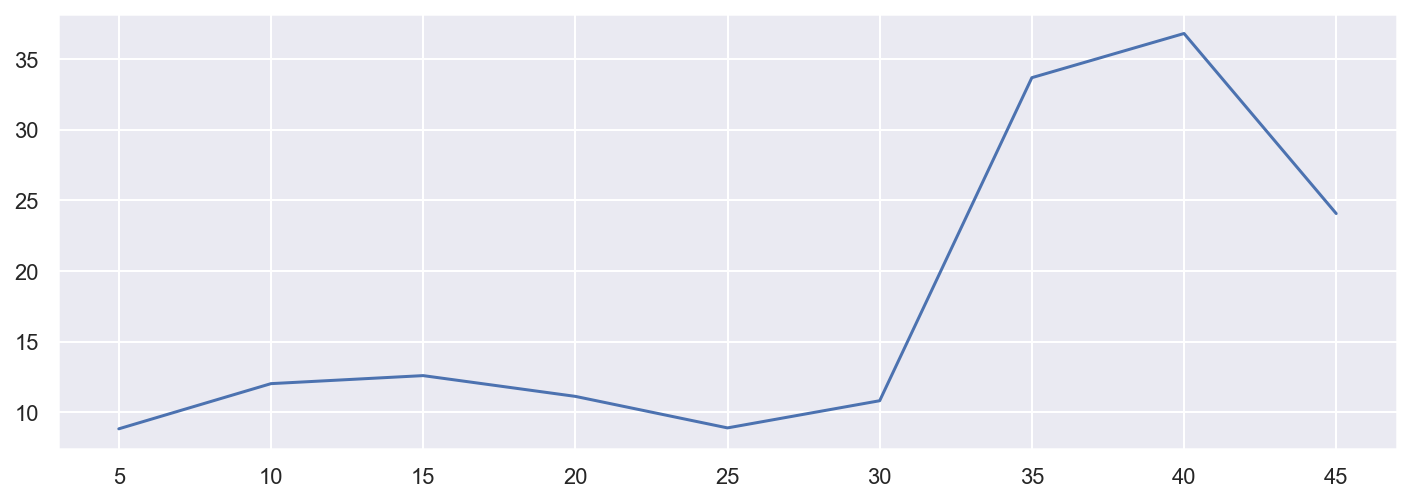

In [22]:
# Performance plot by sequence length
seq_test = pd.DataFrame()
for key, val in Score.items():
    seq_test = pd.concat([seq_test, val.iloc[1,:].T], axis=1)

seq_test = seq_test.T
seq_test.index = batchsize_list
seq_test['MSE'].plot(figsize=(12,4))
plt.show()

### Final

Train_size: (72, 16) Test_size: (24, 16)
X_train: (72, 11) Y_train: (72, 1)
X_test: (24, 11) Y_test: (24, 1)
X_train: (67, 5, 11) Y_train: (67, 1)
X_test: (19, 5, 11) Y_test: (19, 1)
Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_98 (GRU)                 (None, 5, 128)            54144     
_________________________________________________________________
dropout_102 (Dropout)        (None, 5, 128)            0         
_________________________________________________________________
gru_99 (GRU)                 (None, 5, 256)            296448    
_________________________________________________________________
dropout_103 (Dropout)        (None, 5, 256)            0         
_________________________________________________________________
gru_100 (GRU)                (None, 5, 128)            148224    
_________________________________________________________________
dr

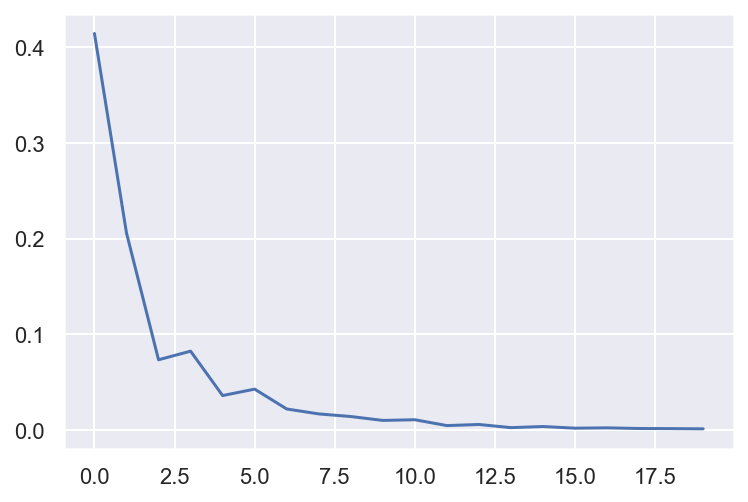

1/1 [==============================] - 0s 996us/step - loss: 7.4794e-15


,MAE,MSE,MAPE
Train,0.34,0.19,0.36
Test,2.83,10.17,2.84


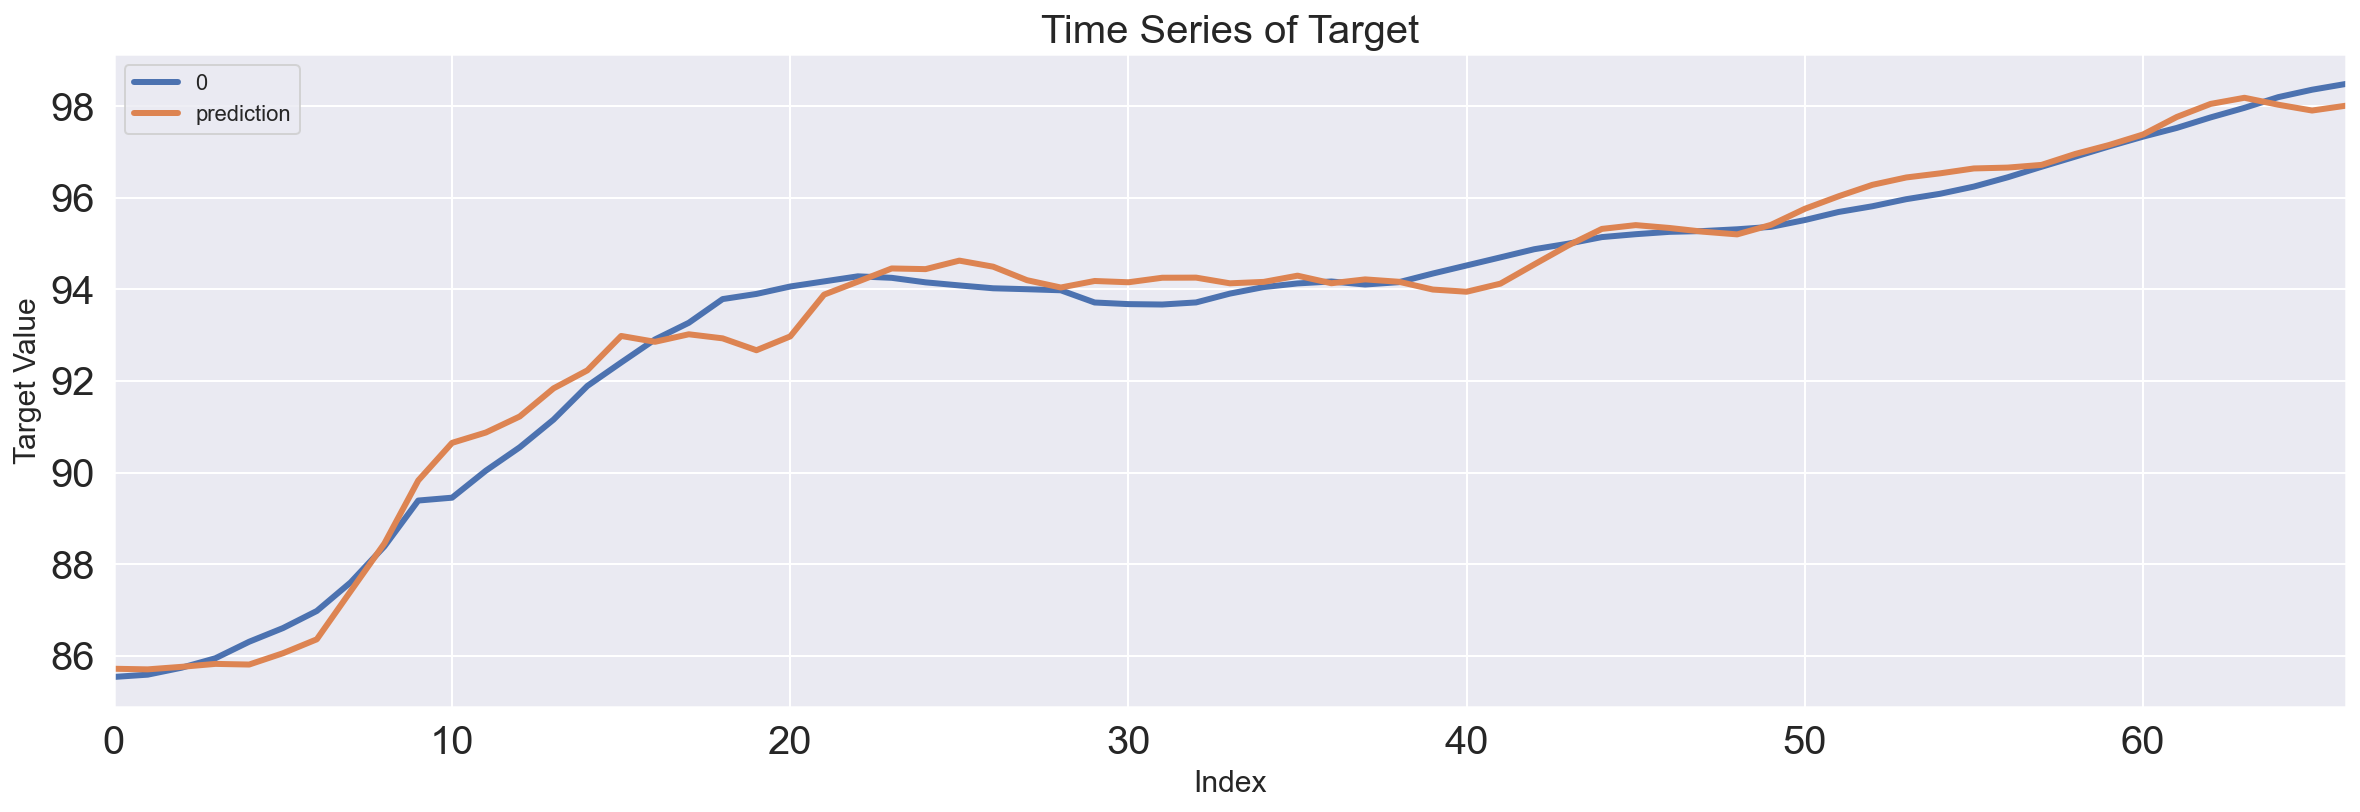

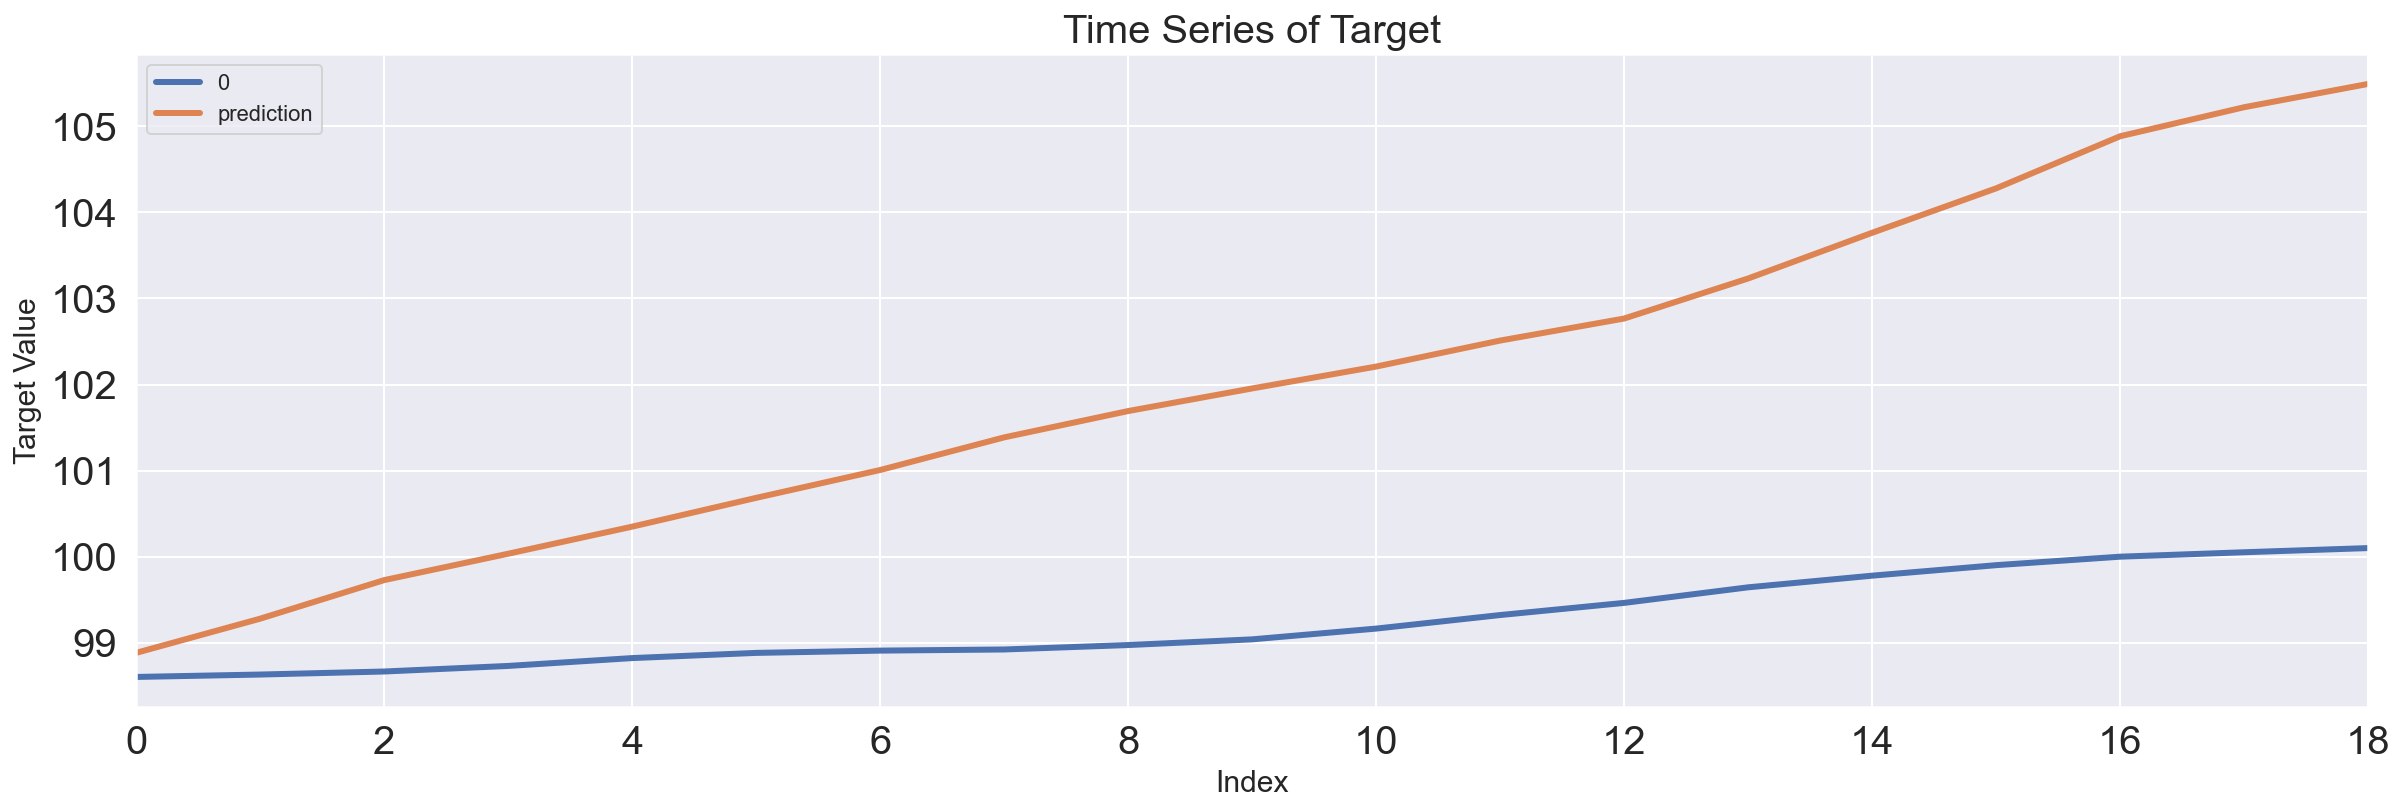

In [23]:
# Data Loading
location = './Data/RealestateKorea_Gangnam/Economy.csv'
raw_all = pd.read_csv(location)
date = raw_all['Date'].unique()
raw_all = raw_all.groupby(['Year', 'Month']).mean().reset_index().iloc[:,2:]
raw_all['Date'] = date
raw_all

# Feature Engineering
raw_all['Date'] = pd.to_datetime(raw_all['Date'])
raw_all.index = raw_all['Date']
raw_all = raw_all[raw_all.index >= '2010-01-01']
raw_all = raw_all[raw_all.index <= '2017-12-31']
raw_all.fillna(method='bfill', inplace=True)

# Data Split
Y_colname = ['Price']
X_remove = ['Date', 'Region', 'Price_Sido', 'Building_Type']
X_colname = [x for x in raw_all.columns if x not in Y_colname+X_remove]
X_train, X_test, Y_train, Y_test = datasplit_ts(raw_all, Y_colname, X_colname, '2016-01-01')

# Parameters
scaler_X_tr = preprocessing.MinMaxScaler()
scaler_Y_tr = preprocessing.MinMaxScaler()
sequence = 5
batch_size = 25
epoch = 20
verbose = 1
dropout_ratio = 0

# Feature Engineering
## Scaling
X_train_scaled = scaler_X_tr.fit_transform(X_train)
Y_train_scaled = scaler_Y_tr.fit_transform(Y_train)
X_test_scaled = scaler_X_tr.transform(X_test)
Y_test_scaled = scaler_Y_tr.transform(Y_test)

## X / Y Split
X_train, Y_train = [], []
for index in range(len(X_train_scaled) - sequence):
    X_train.append(np.array(X_train_scaled[index: index + sequence]))
    Y_train.append(np.ravel(Y_train_scaled[index + sequence:index + sequence + 1]))
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_test, Y_test = [], []
for index in range(len(X_test_scaled) - sequence):
    X_test.append(np.array(X_test_scaled[index: index + sequence]))
    Y_test.append(np.ravel(Y_test_scaled[index + sequence:index + sequence + 1]))  
X_test, Y_test = np.array(X_test), np.array(Y_test) 

## Retype and Reshape
X_train = X_train.reshape(X_train.shape[0], sequence, -1)
X_test = X_test.reshape(X_test.shape[0], sequence, -1)
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

# GRU
model = Sequential()
model.add(GRU(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu'))
model.add(Dropout(dropout_ratio)) 
model.add(GRU(256, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(GRU(128, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(GRU(64, return_sequences=False, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
model_fit = model.fit(X_train, Y_train, 
                      batch_size=batch_size, epochs=epoch,
                      verbose=verbose)

plt.plot(pd.DataFrame(model_fit.history))
plt.grid(True)
plt.show()

# prediction
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

# evaluation
result = model.evaluate(X_test, Y_test_pred)
if scaler_Y_tr != []:
    Y_train = scaler_Y_tr.inverse_transform(Y_train)
    Y_train_pred = scaler_Y_tr.inverse_transform(Y_train_pred)
    Y_test = scaler_Y_tr.inverse_transform(Y_test)
    Y_test_pred = scaler_Y_tr.inverse_transform(Y_test_pred)
Score_GRU, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(Y_train), Y_train_pred.flatten(), 
                                                      pd.DataFrame(Y_test), Y_test_pred.flatten(), graph_on=True)
display(Score_GRU)

# error analysis
# error_analysis(Residual_te, ['Error'], X_test_feR.reset_index().iloc[:,1:].loc[Residual_te.index], graph_on=True)

## Other Case:2

Train_size: (72, 18) Test_size: (24, 18)
X_train: (72, 13) Y_train: (72, 1)
X_test: (24, 13) Y_test: (24, 1)
X_train: (60, 12, 13) Y_train: (60, 1)
X_test: (12, 12, 13) Y_test: (12, 1)
Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_102 (GRU)                (None, 12, 128)           54912     
_________________________________________________________________
dropout_106 (Dropout)        (None, 12, 128)           0         
_________________________________________________________________
gru_103 (GRU)                (None, 12, 256)           296448    
_________________________________________________________________
dropout_107 (Dropout)        (None, 12, 256)           0         
_________________________________________________________________
gru_104 (GRU)                (None, 12, 128)           148224    
_________________________________________________________________


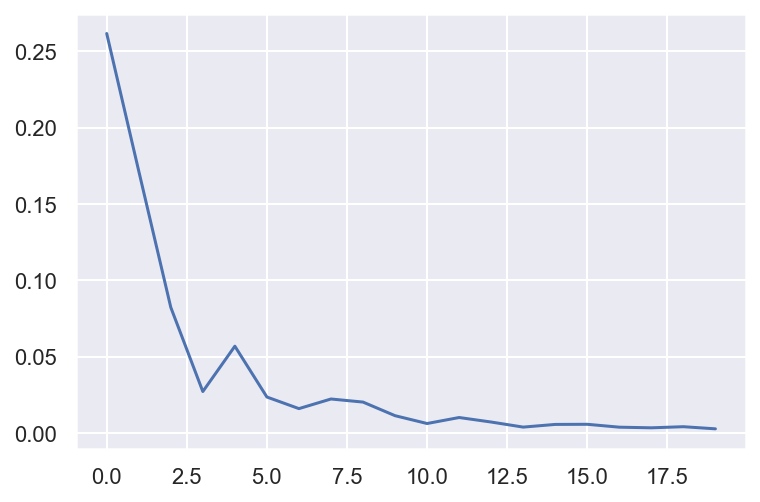

1/1 [==============================] - 0s 0s/step - loss: 2.3685e-15


,MAE,MSE,MAPE
Train,0.78,0.90,0.91
Test,0.41,0.33,0.42


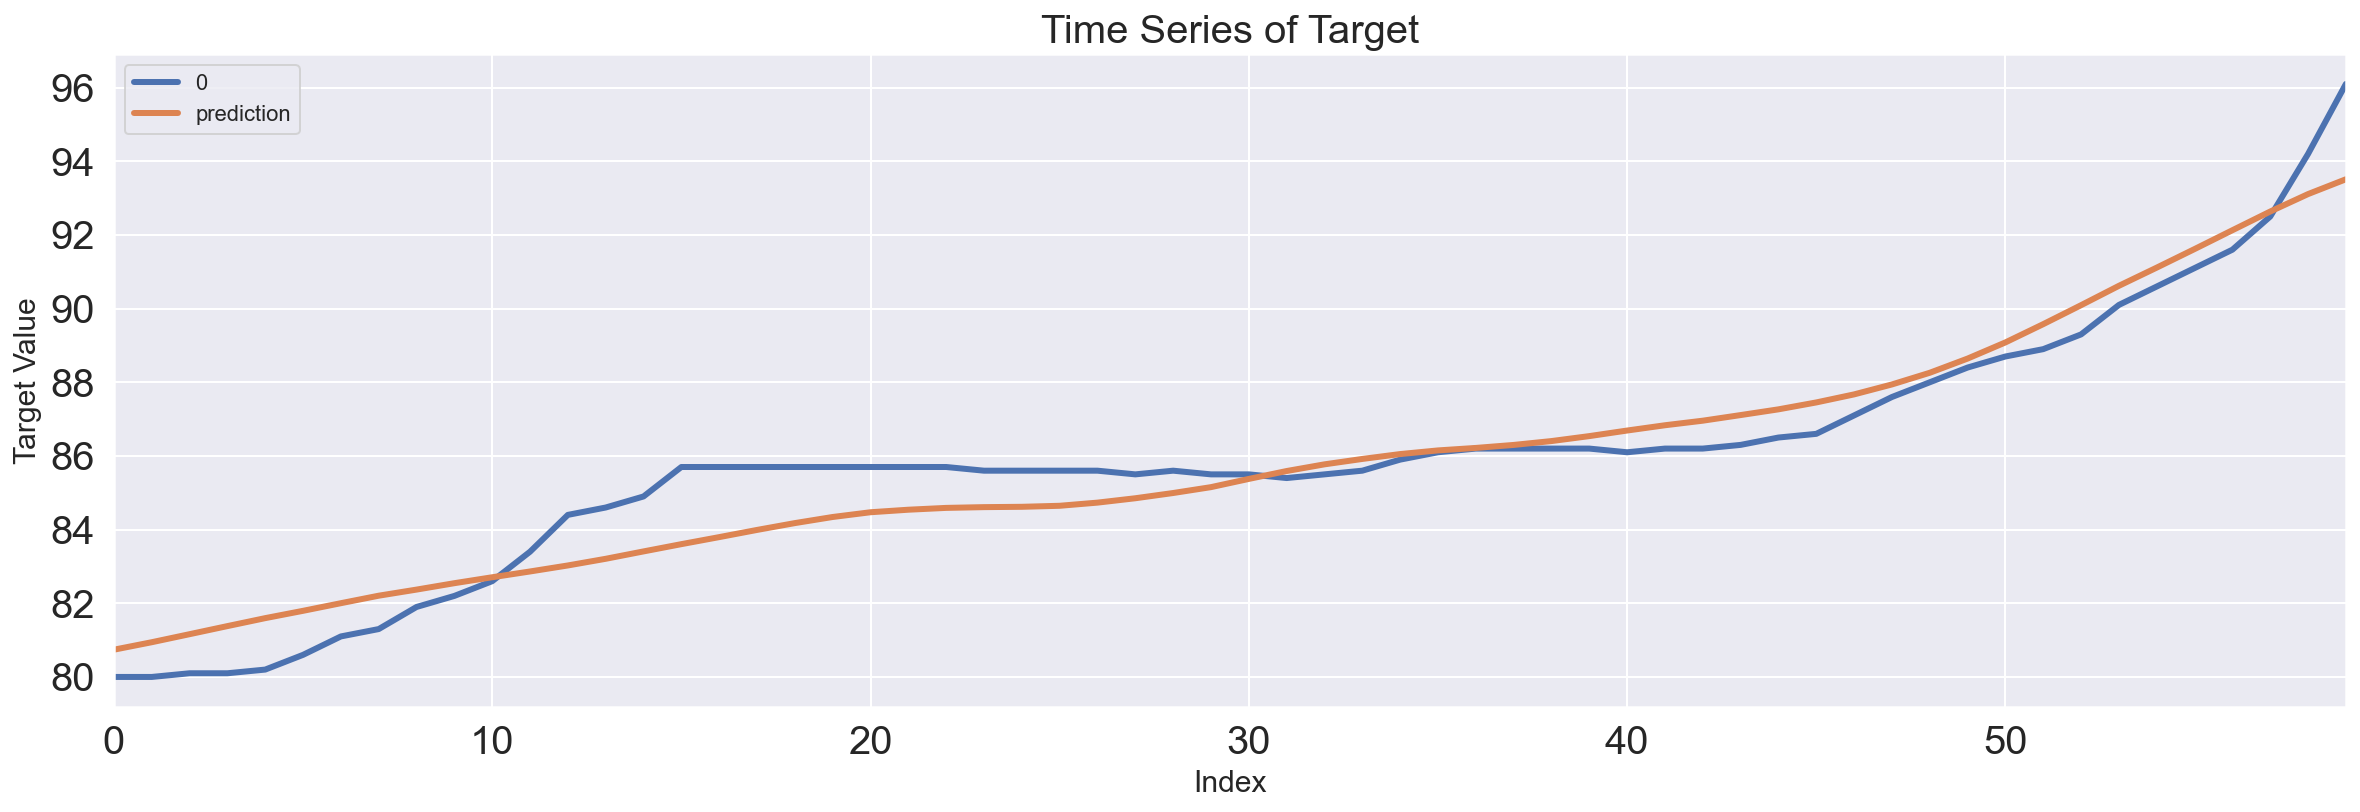

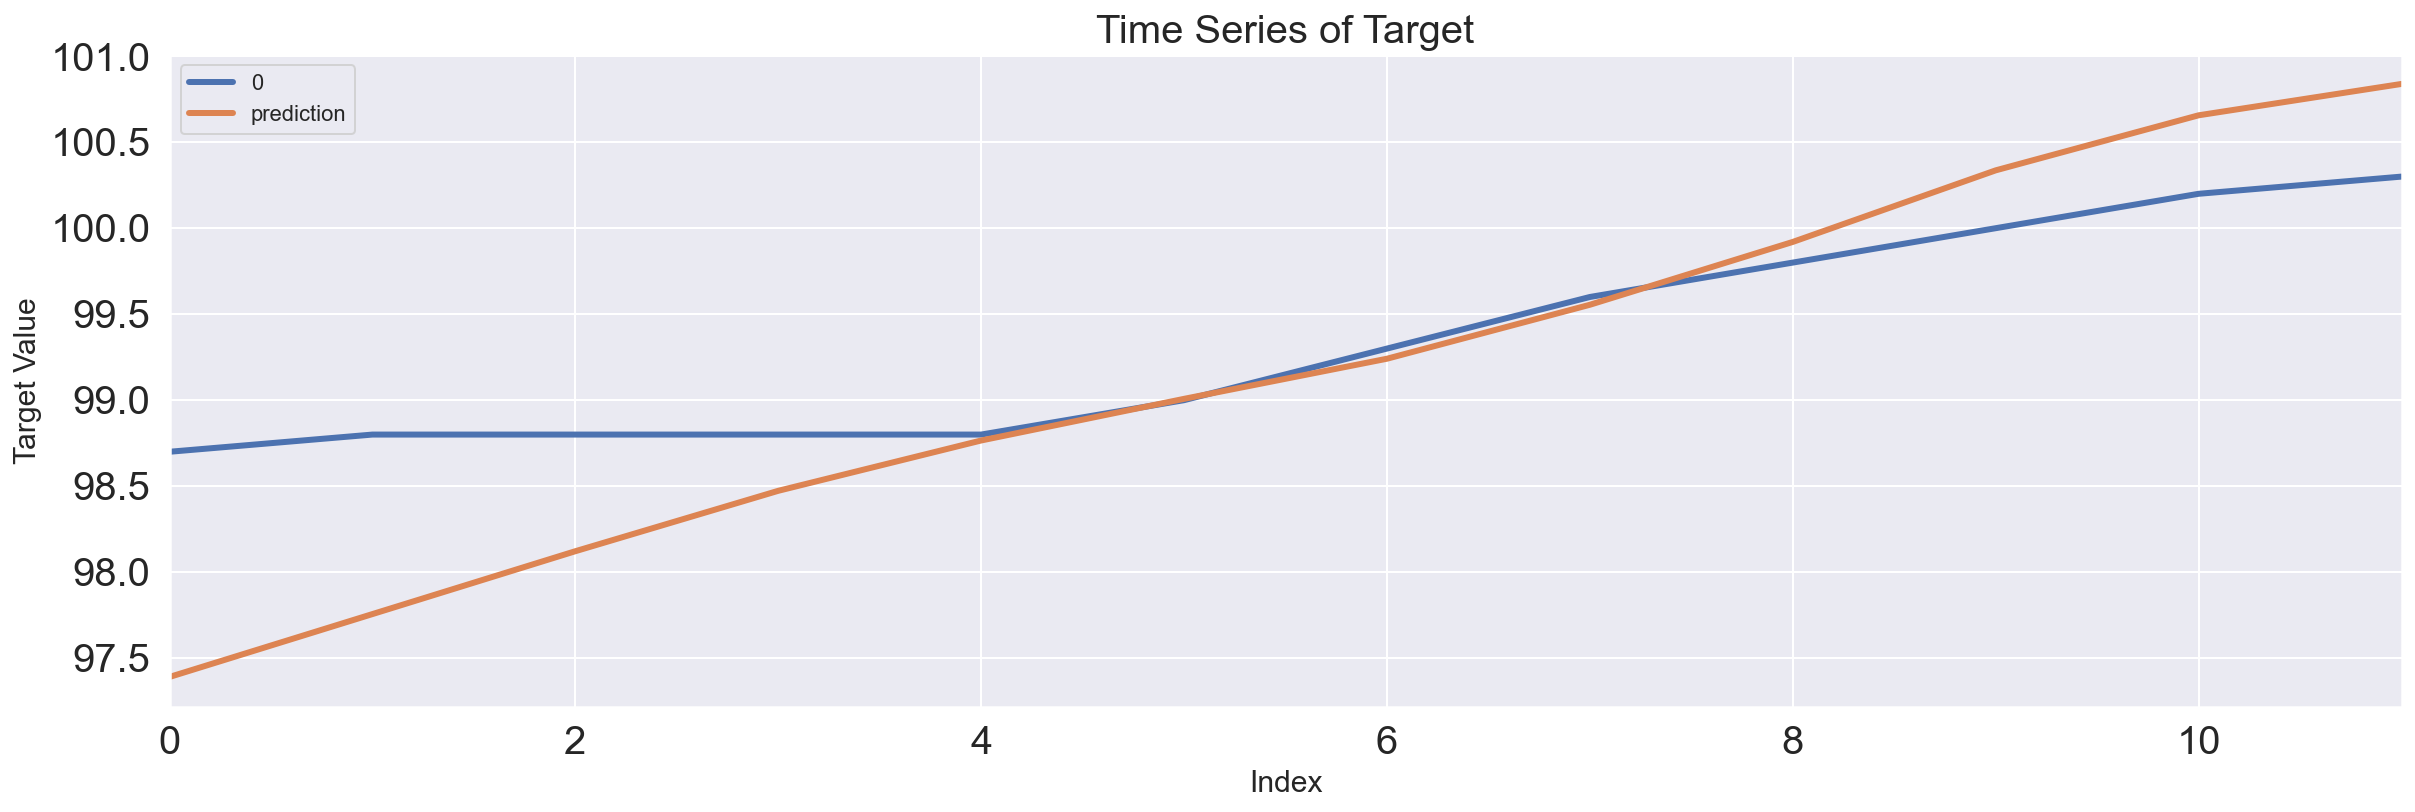

In [24]:
# Data Loading
location = './Data/RealestateKorea_Gangnam/Economy.csv'
raw_all = pd.read_csv(location)
raw_all = raw_all[(raw_all['Region'] == 50000) & (raw_all['Building_Type'] == 0)]
raw_all

# Feature Engineering
raw_all['Date'] = pd.to_datetime(raw_all['Date'])
raw_all.index = raw_all['Date']
raw_all = raw_all[raw_all.index >= '2010-01-01']
raw_all = raw_all[raw_all.index <= '2017-12-31']
raw_all.fillna(method='bfill', inplace=True)

# Data Split
Y_colname = ['Price']
X_remove = ['Date', 'Region', 'Price_Sido', 'Building_Type']
X_colname = [x for x in raw_all.columns if x not in Y_colname+X_remove]
X_train, X_test, Y_train, Y_test = datasplit_ts(raw_all, Y_colname, X_colname, '2016-01-01')

# Parameters
scaler_X_tr = preprocessing.MinMaxScaler()
scaler_Y_tr = preprocessing.MinMaxScaler()
sequence = 12
batch_size = 32
epoch = 20
verbose = 1
dropout_ratio = 0

# Feature Engineering
## Scaling
X_train_scaled = scaler_X_tr.fit_transform(X_train)
Y_train_scaled = scaler_Y_tr.fit_transform(Y_train)
X_test_scaled = scaler_X_tr.transform(X_test)
Y_test_scaled = scaler_Y_tr.transform(Y_test)

## X / Y Split
X_train, Y_train = [], []
for index in range(len(X_train_scaled) - sequence):
    X_train.append(np.array(X_train_scaled[index: index + sequence]))
    Y_train.append(np.ravel(Y_train_scaled[index + sequence:index + sequence + 1]))
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_test, Y_test = [], []
for index in range(len(X_test_scaled) - sequence):
    X_test.append(np.array(X_test_scaled[index: index + sequence]))
    Y_test.append(np.ravel(Y_test_scaled[index + sequence:index + sequence + 1]))  
X_test, Y_test = np.array(X_test), np.array(Y_test) 

## Retype and Reshape
X_train = X_train.reshape(X_train.shape[0], sequence, -1)
X_test = X_test.reshape(X_test.shape[0], sequence, -1)
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

# GRU
model = Sequential()
model.add(GRU(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu'))
model.add(Dropout(dropout_ratio)) 
model.add(GRU(256, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(GRU(128, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(GRU(64, return_sequences=False, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
model_fit = model.fit(X_train, Y_train, 
                      batch_size=batch_size, epochs=epoch,
                      verbose=verbose)

plt.plot(pd.DataFrame(model_fit.history))
plt.grid(True)
plt.show()

# prediction
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

# evaluation
result = model.evaluate(X_test, Y_test_pred)
if scaler_Y_tr != []:
    Y_train = scaler_Y_tr.inverse_transform(Y_train)
    Y_train_pred = scaler_Y_tr.inverse_transform(Y_train_pred)
    Y_test = scaler_Y_tr.inverse_transform(Y_test)
    Y_test_pred = scaler_Y_tr.inverse_transform(Y_test_pred)
Score_GRU, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(Y_train), Y_train_pred.flatten(), 
                                                      pd.DataFrame(Y_test), Y_test_pred.flatten(), graph_on=True)
display(Score_GRU)

# error analysis
# error_analysis(Residual_te, ['Error'], X_test_feR.reset_index().iloc[:,1:].loc[Residual_te.index], graph_on=True)

### Optimal Sequence

In [25]:
# Data Loading
location = './Data/RealestateKorea_Gangnam/Economy.csv'
raw_all = pd.read_csv(location)
raw_all = raw_all[(raw_all['Region'] == 50000) & (raw_all['Building_Type'] == 0)]
raw_all

# Feature Engineering
raw_all['Date'] = pd.to_datetime(raw_all['Date'])
raw_all.index = raw_all['Date']
raw_all = raw_all[raw_all.index >= '2010-01-01']
raw_all = raw_all[raw_all.index <= '2017-12-31']
raw_all.fillna(method='bfill', inplace=True)

# Data Split
Y_colname = ['Price']
X_remove = ['Date', 'Region', 'Price_Sido', 'Building_Type']
X_colname = [x for x in raw_all.columns if x not in Y_colname+X_remove]
X_train, X_test, Y_train, Y_test = datasplit_ts(raw_all, Y_colname, X_colname, '2016-01-01')

# Parameters
scaler_X_tr = preprocessing.MinMaxScaler()
scaler_Y_tr = preprocessing.MinMaxScaler()
sequence = 12
batch_size = 32
epoch = 20
verbose = 0
dropout_ratio = 0

# Feature Engineering
## Scaling
X_train_scaled = scaler_X_tr.fit_transform(X_train)
Y_train_scaled = scaler_Y_tr.fit_transform(Y_train)
X_test_scaled = scaler_X_tr.transform(X_test)
Y_test_scaled = scaler_Y_tr.transform(Y_test)

####################### iterations #######################
Score = dict()
seqsize_list = [i for i in range(1, 15, 1)]
for i in tqdm(seqsize_list):
    sequence = i

    ## X / Y Split
    X_train, Y_train = [], []
    for index in range(len(X_train_scaled) - sequence):
        X_train.append(np.array(X_train_scaled[index: index + sequence]))
        Y_train.append(np.ravel(Y_train_scaled[index + sequence:index + sequence + 1]))
    X_train, Y_train = np.array(X_train), np.array(Y_train)
    X_test, Y_test = [], []
    for index in range(len(X_test_scaled) - sequence):
        X_test.append(np.array(X_test_scaled[index: index + sequence]))
        Y_test.append(np.ravel(Y_test_scaled[index + sequence:index + sequence + 1]))  
    X_test, Y_test = np.array(X_test), np.array(Y_test) 

    ## Retype and Reshape
    X_train = X_train.reshape(X_train.shape[0], sequence, -1)
    X_test = X_test.reshape(X_test.shape[0], sequence, -1)
    print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
    print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

    # GRU
    model = Sequential()
    model.add(GRU(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu'))
    model.add(Dropout(dropout_ratio)) 
    model.add(GRU(256, return_sequences=True, activation="relu"))
    model.add(Dropout(dropout_ratio)) 
    model.add(GRU(128, return_sequences=True, activation="relu"))
    model.add(Dropout(dropout_ratio)) 
    model.add(GRU(64, return_sequences=False, activation="relu"))
    model.add(Dropout(dropout_ratio)) 
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    # model.summary()
    model_fit = model.fit(X_train, Y_train, 
                          batch_size=batch_size, epochs=epoch,
                          verbose=verbose)

    # plt.plot(pd.DataFrame(model_fit.history))
    # plt.grid(True)
    # plt.show()

    # prediction
    Y_train_pred = model.predict(X_train)
    Y_test_pred = model.predict(X_test)

    # evaluation
    result = model.evaluate(X_test, Y_test_pred)
    if scaler_Y_tr != []:
        Y_train = scaler_Y_tr.inverse_transform(Y_train)
        Y_train_pred = scaler_Y_tr.inverse_transform(Y_train_pred)
        Y_test = scaler_Y_tr.inverse_transform(Y_test)
        Y_test_pred = scaler_Y_tr.inverse_transform(Y_test_pred)
    Score_GRU, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(Y_train), Y_train_pred.flatten(), 
                                                          pd.DataFrame(Y_test), Y_test_pred.flatten(), graph_on=False)
#     display(Score_GRU)
    Score[str(sequence)] = Score_GRU

    # error analysis
    # error_analysis(Residual_te, ['Error'], X_test_feR.reset_index().iloc[:,1:].loc[Residual_te.index], graph_on=True)

  0%|          | 0/14 [00:00<?, ?it/s]

Train_size: (72, 18) Test_size: (24, 18)
X_train: (72, 13) Y_train: (72, 1)
X_test: (24, 13) Y_test: (24, 1)
X_train: (71, 1, 13) Y_train: (71, 1)
X_test: (23, 1, 13) Y_test: (23, 1)
1/1 [==============================] - 0s 999us/step - loss: 4.4795e-15


  7%|▋         | 1/14 [00:09<02:08,  9.89s/it]

X_train: (70, 2, 13) Y_train: (70, 1)
X_test: (22, 2, 13) Y_test: (22, 1)
1/1 [==============================] - 0s 2ms/step - loss: 7.7514e-15


 14%|█▍        | 2/14 [00:20<02:00, 10.05s/it]

X_train: (69, 3, 13) Y_train: (69, 1)
X_test: (21, 3, 13) Y_test: (21, 1)
1/1 [==============================] - 0s 997us/step - loss: 3.5527e-15


 21%|██▏       | 3/14 [00:31<01:55, 10.46s/it]

X_train: (68, 4, 13) Y_train: (68, 1)
X_test: (20, 4, 13) Y_test: (20, 1)
1/1 [==============================] - 0s 989us/step - loss: 1.5987e-15


 29%|██▊       | 4/14 [00:41<01:46, 10.66s/it]

X_train: (67, 5, 13) Y_train: (67, 1)
X_test: (19, 5, 13) Y_test: (19, 1)
1/1 [==============================] - 0s 2ms/step - loss: 5.6095e-15


 36%|███▌      | 5/14 [00:52<01:36, 10.70s/it]

X_train: (66, 6, 13) Y_train: (66, 1)
X_test: (18, 6, 13) Y_test: (18, 1)
1/1 [==============================] - 0s 998us/step - loss: 7.3028e-15


 43%|████▎     | 6/14 [01:04<01:27, 10.97s/it]

X_train: (65, 7, 13) Y_train: (65, 1)
X_test: (17, 7, 13) Y_test: (17, 1)
1/1 [==============================] - 0s 0s/step - loss: 1.2539e-15


 50%|█████     | 7/14 [01:16<01:18, 11.26s/it]

X_train: (64, 8, 13) Y_train: (64, 1)
X_test: (16, 8, 13) Y_test: (16, 1)
1/1 [==============================] - 0s 8ms/step - loss: 7.3275e-15


 57%|█████▋    | 8/14 [01:23<00:59,  9.88s/it]

X_train: (63, 9, 13) Y_train: (63, 1)
X_test: (15, 9, 13) Y_test: (15, 1)
1/1 [==============================] - 0s 1000us/step - loss: 6.6317e-15


 64%|██████▍   | 9/14 [01:32<00:48,  9.79s/it]

X_train: (62, 10, 13) Y_train: (62, 1)
X_test: (14, 10, 13) Y_test: (14, 1)
1/1 [==============================] - 0s 2ms/step - loss: 6.0904e-15


 71%|███████▏  | 10/14 [01:42<00:39,  9.93s/it]

X_train: (61, 11, 13) Y_train: (61, 1)
X_test: (13, 11, 13) Y_test: (13, 1)
1/1 [==============================] - 0s 0s/step - loss: 7.6520e-15


 79%|███████▊  | 11/14 [01:52<00:29,  9.91s/it]

X_train: (60, 12, 13) Y_train: (60, 1)
X_test: (12, 12, 13) Y_test: (12, 1)
1/1 [==============================] - 0s 0s/step - loss: 4.7370e-15


 86%|████████▌ | 12/14 [02:02<00:19,  9.81s/it]

X_train: (59, 13, 13) Y_train: (59, 1)
X_test: (11, 13, 13) Y_test: (11, 1)
1/1 [==============================] - 0s 0s/step - loss: 9.0433e-15


 93%|█████████▎| 13/14 [02:11<00:09,  9.70s/it]

X_train: (58, 14, 13) Y_train: (58, 1)
X_test: (10, 14, 13) Y_test: (10, 1)
1/1 [==============================] - 0s 0s/step - loss: 2.8422e-15


100%|██████████| 14/14 [02:21<00:00, 10.14s/it]


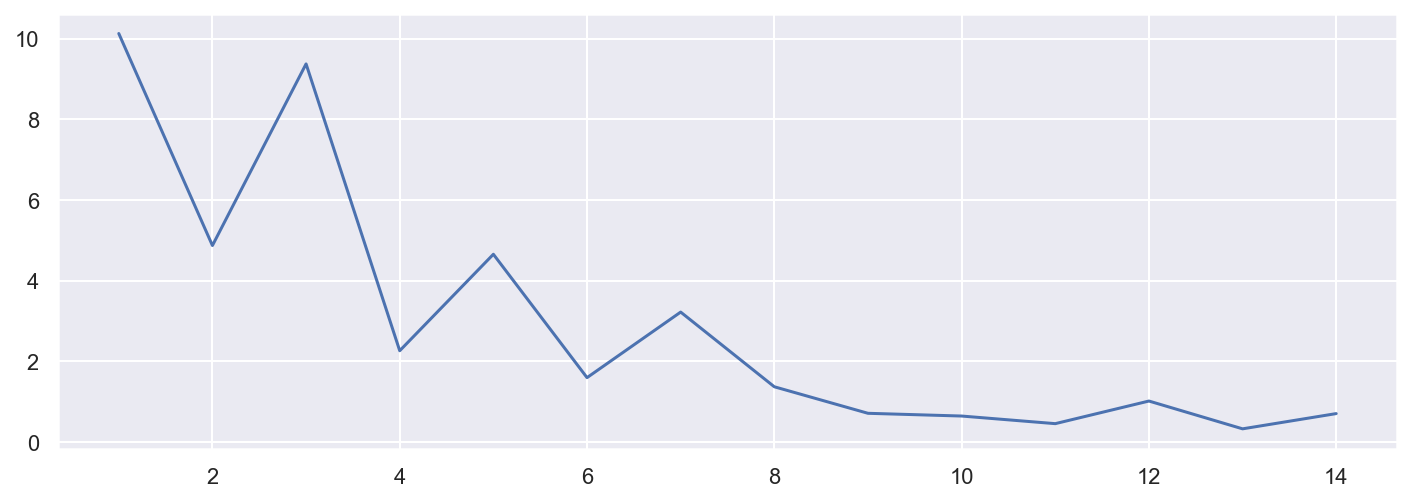

In [26]:
# Performance plot by sequence length
seq_test = pd.DataFrame()
for key, val in Score.items():
    seq_test = pd.concat([seq_test, val.iloc[1,:].T], axis=1)

seq_test = seq_test.T
seq_test.index = seqsize_list
seq_test['MSE'].plot(figsize=(12,4))
plt.show()

### Optimal Batchsize

In [27]:
# Data Loading
location = './Data/RealestateKorea_Gangnam/Economy.csv'
raw_all = pd.read_csv(location)
raw_all = raw_all[(raw_all['Region'] == 50000) & (raw_all['Building_Type'] == 0)]
raw_all

# Feature Engineering
raw_all['Date'] = pd.to_datetime(raw_all['Date'])
raw_all.index = raw_all['Date']
raw_all = raw_all[raw_all.index >= '2010-01-01']
raw_all = raw_all[raw_all.index <= '2017-12-31']
raw_all.fillna(method='bfill', inplace=True)

# Data Split
Y_colname = ['Price']
X_remove = ['Date', 'Region', 'Price_Sido', 'Building_Type']
X_colname = [x for x in raw_all.columns if x not in Y_colname+X_remove]
X_train, X_test, Y_train, Y_test = datasplit_ts(raw_all, Y_colname, X_colname, '2016-01-01')

# Parameters
scaler_X_tr = preprocessing.MinMaxScaler()
scaler_Y_tr = preprocessing.MinMaxScaler()
sequence = 10
batch_size = 32
epoch = 20
verbose = 0
dropout_ratio = 0

# Feature Engineering
## Scaling
X_train_scaled = scaler_X_tr.fit_transform(X_train)
Y_train_scaled = scaler_Y_tr.fit_transform(Y_train)
X_test_scaled = scaler_X_tr.transform(X_test)
Y_test_scaled = scaler_Y_tr.transform(Y_test)

####################### iterations #######################
Score = dict()
batchsize_list = [i for i in range(5, 50, 5)]
for i in tqdm(batchsize_list):
    batch_size = i

    ## X / Y Split
    X_train, Y_train = [], []
    for index in range(len(X_train_scaled) - sequence):
        X_train.append(np.array(X_train_scaled[index: index + sequence]))
        Y_train.append(np.ravel(Y_train_scaled[index + sequence:index + sequence + 1]))
    X_train, Y_train = np.array(X_train), np.array(Y_train)
    X_test, Y_test = [], []
    for index in range(len(X_test_scaled) - sequence):
        X_test.append(np.array(X_test_scaled[index: index + sequence]))
        Y_test.append(np.ravel(Y_test_scaled[index + sequence:index + sequence + 1]))  
    X_test, Y_test = np.array(X_test), np.array(Y_test) 

    ## Retype and Reshape
    X_train = X_train.reshape(X_train.shape[0], sequence, -1)
    X_test = X_test.reshape(X_test.shape[0], sequence, -1)
    print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
    print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

    # GRU
    model = Sequential()
    model.add(GRU(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu'))
    model.add(Dropout(dropout_ratio)) 
    model.add(GRU(256, return_sequences=True, activation="relu"))
    model.add(Dropout(dropout_ratio)) 
    model.add(GRU(128, return_sequences=True, activation="relu"))
    model.add(Dropout(dropout_ratio)) 
    model.add(GRU(64, return_sequences=False, activation="relu"))
    model.add(Dropout(dropout_ratio)) 
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    # model.summary()
    model_fit = model.fit(X_train, Y_train, 
                          batch_size=batch_size, epochs=epoch,
                          verbose=verbose)

    # plt.plot(pd.DataFrame(model_fit.history))
    # plt.grid(True)
    # plt.show()

    # prediction
    Y_train_pred = model.predict(X_train)
    Y_test_pred = model.predict(X_test)

    # evaluation
    result = model.evaluate(X_test, Y_test_pred)
    if scaler_Y_tr != []:
        Y_train = scaler_Y_tr.inverse_transform(Y_train)
        Y_train_pred = scaler_Y_tr.inverse_transform(Y_train_pred)
        Y_test = scaler_Y_tr.inverse_transform(Y_test)
        Y_test_pred = scaler_Y_tr.inverse_transform(Y_test_pred)
    Score_GRU, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(Y_train), Y_train_pred.flatten(), 
                                                          pd.DataFrame(Y_test), Y_test_pred.flatten(), graph_on=False)
#     display(Score_GRU)
    Score[str(batch_size)] = Score_GRU

    # error analysis
    # error_analysis(Residual_te, ['Error'], X_test_feR.reset_index().iloc[:,1:].loc[Residual_te.index], graph_on=True)

  0%|          | 0/9 [00:00<?, ?it/s]

Train_size: (72, 18) Test_size: (24, 18)
X_train: (72, 13) Y_train: (72, 1)
X_test: (24, 13) Y_test: (24, 1)
X_train: (62, 10, 13) Y_train: (62, 1)
X_test: (14, 10, 13) Y_test: (14, 1)
1/1 [==============================] - 0s 0s/step - loss: 8.1205e-15


 11%|█         | 1/9 [00:15<02:02, 15.30s/it]

X_train: (62, 10, 13) Y_train: (62, 1)
X_test: (14, 10, 13) Y_test: (14, 1)
1/1 [==============================] - 0s 0s/step - loss: 1.1166e-14


 22%|██▏       | 2/9 [00:26<01:29, 12.84s/it]

X_train: (62, 10, 13) Y_train: (62, 1)
X_test: (14, 10, 13) Y_test: (14, 1)
1/1 [==============================] - 0s 0s/step - loss: 7.1054e-15


 33%|███▎      | 3/9 [00:36<01:09, 11.65s/it]

X_train: (62, 10, 13) Y_train: (62, 1)
X_test: (14, 10, 13) Y_test: (14, 1)
1/1 [==============================] - 0s 16ms/step - loss: 4.0602e-15


 44%|████▍     | 4/9 [00:46<00:54, 10.95s/it]

X_train: (62, 10, 13) Y_train: (62, 1)
X_test: (14, 10, 13) Y_test: (14, 1)
1/1 [==============================] - 0s 0s/step - loss: 4.0602e-15


 56%|█████▌    | 5/9 [00:56<00:42, 10.54s/it]

X_train: (62, 10, 13) Y_train: (62, 1)
X_test: (14, 10, 13) Y_test: (14, 1)
1/1 [==============================] - 0s 1ms/step - loss: 4.0602e-15


 67%|██████▋   | 6/9 [01:05<00:30, 10.21s/it]

X_train: (62, 10, 13) Y_train: (62, 1)
X_test: (14, 10, 13) Y_test: (14, 1)
1/1 [==============================] - 0s 16ms/step - loss: 8.3743e-15


 78%|███████▊  | 7/9 [01:14<00:19,  9.68s/it]

X_train: (62, 10, 13) Y_train: (62, 1)
X_test: (14, 10, 13) Y_test: (14, 1)
1/1 [==============================] - 0s 0s/step - loss: 9.1355e-15


 89%|████████▉ | 8/9 [01:23<00:09,  9.59s/it]

X_train: (62, 10, 13) Y_train: (62, 1)
X_test: (14, 10, 13) Y_test: (14, 1)
1/1 [==============================] - 0s 996us/step - loss: 5.3291e-15


100%|██████████| 9/9 [01:34<00:00, 10.54s/it]


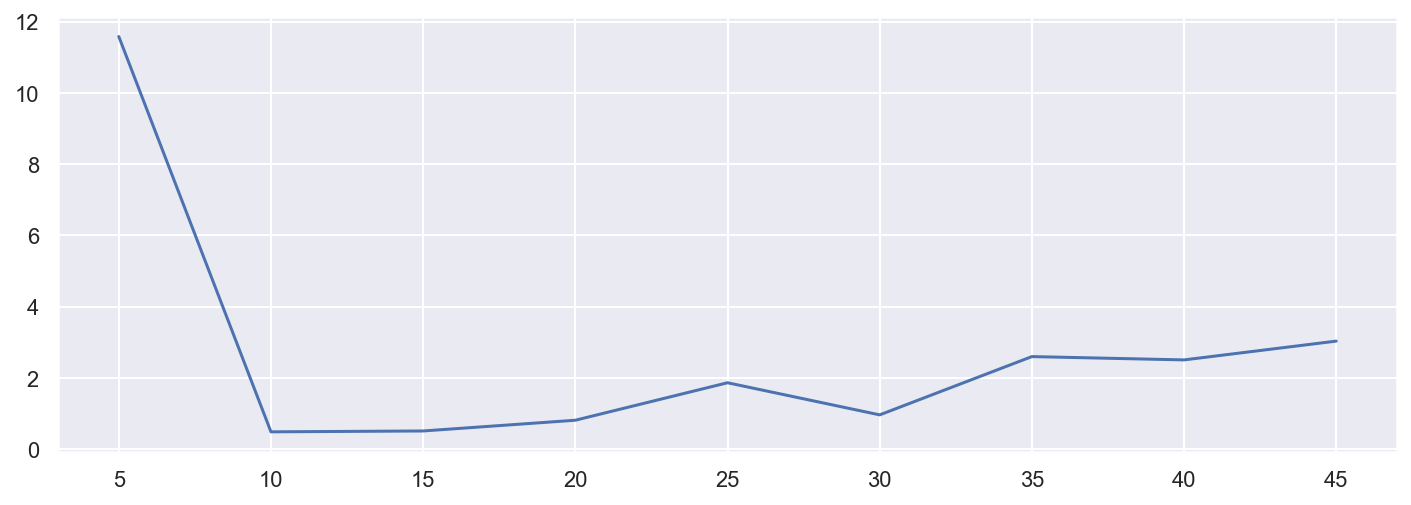

In [28]:
# Performance plot by sequence length
seq_test = pd.DataFrame()
for key, val in Score.items():
    seq_test = pd.concat([seq_test, val.iloc[1,:].T], axis=1)

seq_test = seq_test.T
seq_test.index = batchsize_list
seq_test['MSE'].plot(figsize=(12,4))
plt.show()

### Final

Train_size: (72, 18) Test_size: (24, 18)
X_train: (72, 13) Y_train: (72, 1)
X_test: (24, 13) Y_test: (24, 1)
X_train: (62, 10, 13) Y_train: (62, 1)
X_test: (14, 10, 13) Y_test: (14, 1)
Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_198 (GRU)                (None, 10, 128)           54912     
_________________________________________________________________
dropout_202 (Dropout)        (None, 10, 128)           0         
_________________________________________________________________
gru_199 (GRU)                (None, 10, 256)           296448    
_________________________________________________________________
dropout_203 (Dropout)        (None, 10, 256)           0         
_________________________________________________________________
gru_200 (GRU)                (None, 10, 128)           148224    
_________________________________________________________________


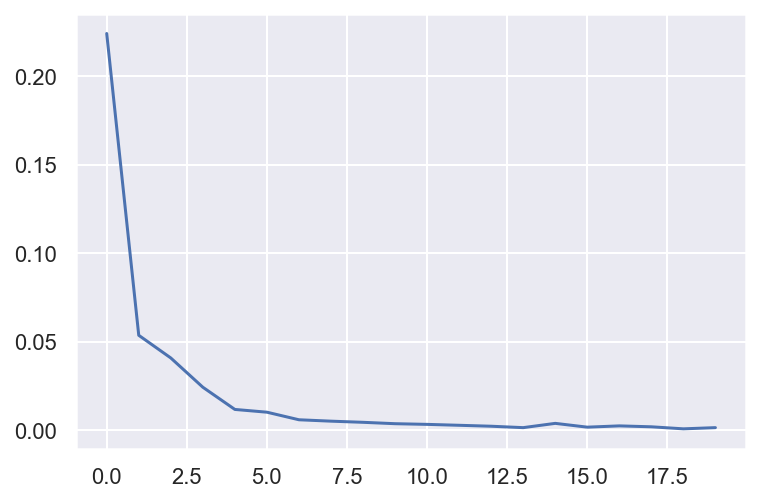

1/1 [==============================] - 0s 998us/step - loss: 1.3196e-14


,MAE,MSE,MAPE
Train,0.35,0.23,0.40
Test,0.78,0.71,0.78


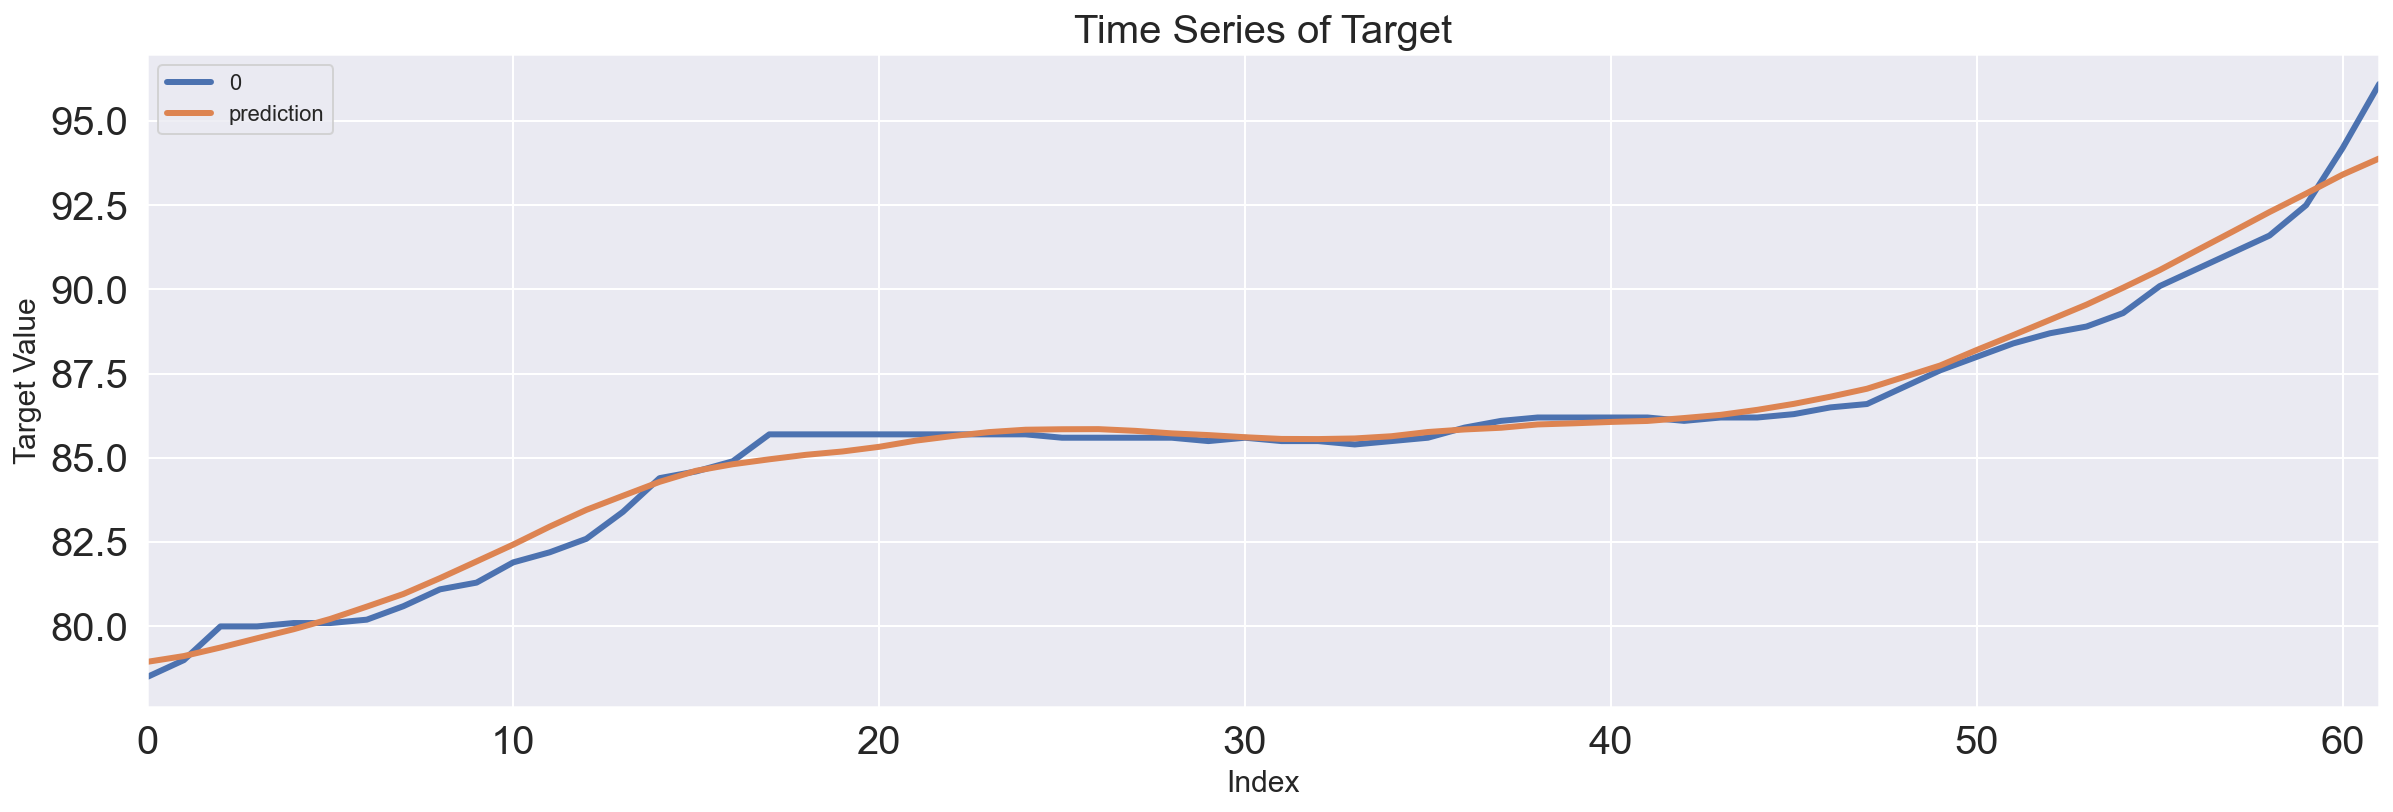

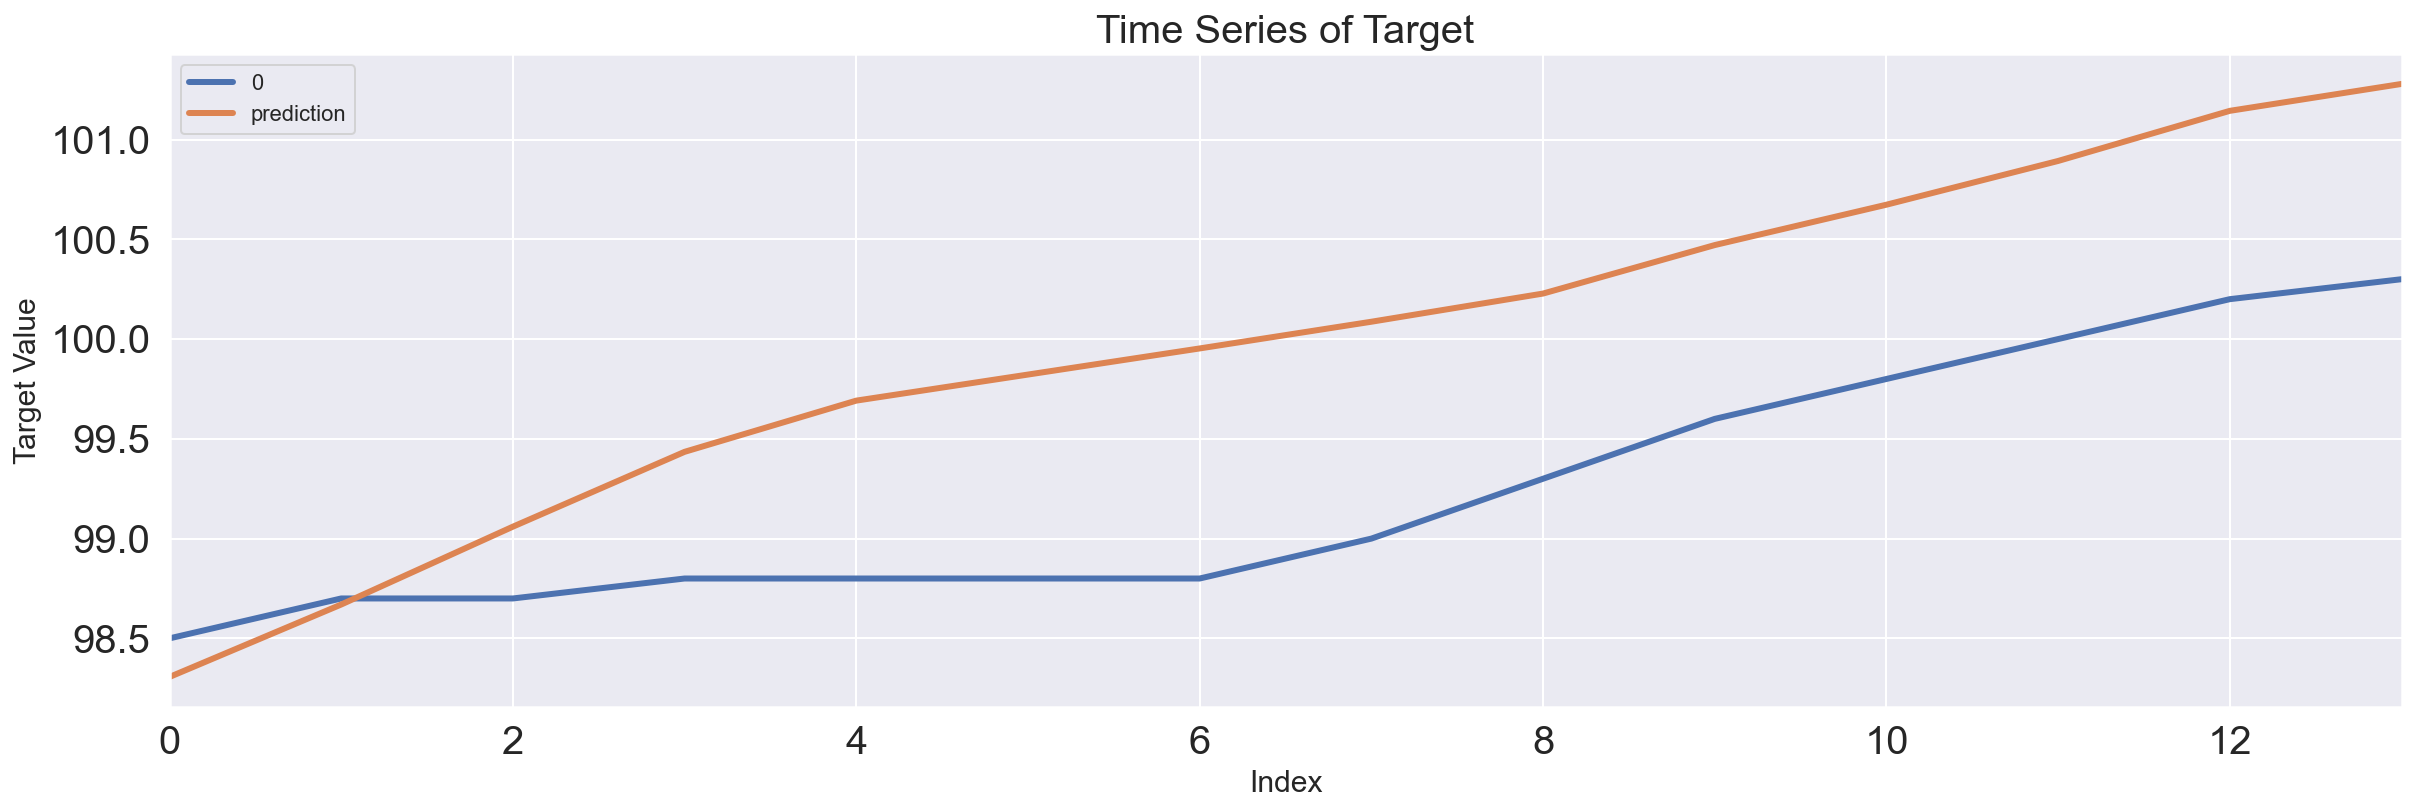

In [29]:
# Data Loading
location = './Data/RealestateKorea_Gangnam/Economy.csv'
raw_all = pd.read_csv(location)
raw_all = raw_all[(raw_all['Region'] == 50000) & (raw_all['Building_Type'] == 0)]
raw_all

# Feature Engineering
raw_all['Date'] = pd.to_datetime(raw_all['Date'])
raw_all.index = raw_all['Date']
raw_all = raw_all[raw_all.index >= '2010-01-01']
raw_all = raw_all[raw_all.index <= '2017-12-31']
raw_all.fillna(method='bfill', inplace=True)

# Data Split
Y_colname = ['Price']
X_remove = ['Date', 'Region', 'Price_Sido', 'Building_Type']
X_colname = [x for x in raw_all.columns if x not in Y_colname+X_remove]
X_train, X_test, Y_train, Y_test = datasplit_ts(raw_all, Y_colname, X_colname, '2016-01-01')

# Parameters
scaler_X_tr = preprocessing.MinMaxScaler()
scaler_Y_tr = preprocessing.MinMaxScaler()
sequence = 10
batch_size = 20
epoch = 20
verbose = 1
dropout_ratio = 0

# Feature Engineering
## Scaling
X_train_scaled = scaler_X_tr.fit_transform(X_train)
Y_train_scaled = scaler_Y_tr.fit_transform(Y_train)
X_test_scaled = scaler_X_tr.transform(X_test)
Y_test_scaled = scaler_Y_tr.transform(Y_test)

## X / Y Split
X_train, Y_train = [], []
for index in range(len(X_train_scaled) - sequence):
    X_train.append(np.array(X_train_scaled[index: index + sequence]))
    Y_train.append(np.ravel(Y_train_scaled[index + sequence:index + sequence + 1]))
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_test, Y_test = [], []
for index in range(len(X_test_scaled) - sequence):
    X_test.append(np.array(X_test_scaled[index: index + sequence]))
    Y_test.append(np.ravel(Y_test_scaled[index + sequence:index + sequence + 1]))  
X_test, Y_test = np.array(X_test), np.array(Y_test) 

## Retype and Reshape
X_train = X_train.reshape(X_train.shape[0], sequence, -1)
X_test = X_test.reshape(X_test.shape[0], sequence, -1)
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

# GRU
model = Sequential()
model.add(GRU(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu'))
model.add(Dropout(dropout_ratio)) 
model.add(GRU(256, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(GRU(128, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(GRU(64, return_sequences=False, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
model_fit = model.fit(X_train, Y_train, 
                      batch_size=batch_size, epochs=epoch,
                      verbose=verbose)

plt.plot(pd.DataFrame(model_fit.history))
plt.grid(True)
plt.show()

# prediction
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

# evaluation
result = model.evaluate(X_test, Y_test_pred)
if scaler_Y_tr != []:
    Y_train = scaler_Y_tr.inverse_transform(Y_train)
    Y_train_pred = scaler_Y_tr.inverse_transform(Y_train_pred)
    Y_test = scaler_Y_tr.inverse_transform(Y_test)
    Y_test_pred = scaler_Y_tr.inverse_transform(Y_test_pred)
Score_GRU, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(Y_train), Y_train_pred.flatten(), 
                                                      pd.DataFrame(Y_test), Y_test_pred.flatten(), graph_on=True)
display(Score_GRU)

# error analysis
# error_analysis(Residual_te, ['Error'], X_test_feR.reset_index().iloc[:,1:].loc[Residual_te.index], graph_on=True)